Convolutions and character embeddings
======================

The project aims to predict the language from which a character sequence comes from. This is done with surnames and it involves a dozen of languages.

Data download & description
---------------------

In [ ]:
import matplotlib.pyplot as plt
import itertools

In [ ]:
from urllib.request import urlretrieve

urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.train','name2lang.train')
urlretrieve('http://www.linguist.univ-paris-diderot.fr/~bcrabbe/datasets/name2lang.valid','name2lang.valid')

#Prints the beginning of the valid set
istream = open('name2lang.valid')
for idx, line in enumerate(istream):
  print(line.strip())
  if idx >=20:
    break
istream.close()

Barros, Portuguese
Campos, Portuguese
D'cruz, Portuguese
Henriques, Portuguese
Machado, Portuguese
Silva, Portuguese
Torres, Portuguese
Ahearn, Irish
Aonghus, Irish
Brady, Irish
Cearbhall, Irish
Flann, Irish
Kavanagh, Irish
Maguire, Irish
Mcmahon, Irish
Mcneil, Irish
Monahan, Irish
Muirchertach, Irish
Mullen, Irish
O'Connell, Irish
O'Grady, Irish


## 1. Data preprocessing
---
Creating encodings from integers to strings and from strings to integers.

In [ ]:
def vocabulary(filename,char_vocab,pad_token='<pad>'):
    """
    Args:
      filename (str)    : the name of the file
      char_vocab (bool) : selects if we extact char symbols  or language codes
      pad_token(str)    : the value of the pad symbol
    """
    # Map ids and symbols
    idx2sym = []
    sym2idx = {}

    with open(filename, "r", encoding="utf-8") as file:
      i = 0
      if char_vocab:
        idx2sym.append(pad_token)
        sym2idx[pad_token] = i
        i +=1
      for line in file:
        line = line.split(",")
        #char_vocab is a boolean flag that tells if we extract char symbols or language codes
        if char_vocab:
        # Extract char symbols
            for char in line[0]:
              if char not in idx2sym:
                idx2sym.append(char)
                sym2idx[char] = i
                i +=1
        else:
          # Extract language codes
          lang = line[1].replace("\n", "")
          lang = lang.replace(" ", "")
          if lang not in idx2sym:
            idx2sym.append(lang)
            sym2idx[lang] = i
            i+=1
    #TODO : return the two encoding maps idx2sym and sym2idx as a couple
    return idx2sym, sym2idx

vocabulary("name2lang.valid", False)

(['Portuguese',
  'Irish',
  'Spanish',
  'Vietnamese',
  'Chinese',
  'Greek',
  'Czech',
  'Dutch',
  'Japanese',
  'French',
  'German',
  'Scottish',
  'English',
  'Russian',
  'Polish',
  'Arabic',
  'Korean',
  'Italian'],
 {'Portuguese': 0,
  'Irish': 1,
  'Spanish': 2,
  'Vietnamese': 3,
  'Chinese': 4,
  'Greek': 5,
  'Czech': 6,
  'Dutch': 7,
  'Japanese': 8,
  'French': 9,
  'German': 10,
  'Scottish': 11,
  'English': 12,
  'Russian': 13,
  'Polish': 14,
  'Arabic': 15,
  'Korean': 16,
  'Italian': 17})

In [ ]:
# Padding consists in adding tokens to make sure the window doesn't take empty embeddings
#returns a list with additional pad tokens to match pad_size if needed
def pad_sequence(sequence,pad_size,pad_token):
    """
    Args:
      sequence (list): The input sequence as a list of tokens.
      pad_size (int): The desired size of the padded sequence.
      pad_token: The padding token to use.

    Returns:
      list: The padded sequence.
    """
    while len(sequence) < pad_size:
      sequence.append(pad_token)
    return sequence

def code_sequence(charseq,encodingmap):
  #we ignore chars not seen in train set
  #charseq is a sequence of chars
  return [encodingmap[c] for c in charseq if c in encodingmap]

def decode_sequence(idxseq,decodingmap):
  #idxseq is a list of integers
  return [decodingmap[idx] for idx in idxseq]

## 2. Data generator
------------

The data generator aims to deliver efficiently well formed batches of data to the model.

In [ ]:
def read_dataset(filename,input_symbols):
    #reads from a raw datafile, either the surnmaes if input_symbols is True otherwise it reads the language
    symbols = []
    istream = open(filename)
    for line in istream:
      if line and not line.isspace():
        word,lang = line.split(',')
        symbol = list(word.strip()) if input_symbols else lang.strip()
        symbols.append(symbol)
    istream.close()
    return symbols

In [ ]:
from random import shuffle

class DataGenerator:

      def __init__(self,filename, parentgenerator=None, pad_token='<pad>'):

           self.pad_token = pad_token
           if parentgenerator is not None: #Reuse the encodings of the parent if specified
             self.input_idx2sym,self.input_sym2idx     = parentgenerator.input_idx2sym,parentgenerator.input_sym2idx
             self.output_idx2sym,self.output_sym2idx   = parentgenerator.output_idx2sym,parentgenerator.output_sym2idx
           else:
             #######################################
             self.input_idx2sym,self.input_sym2idx     = vocabulary(filename, char_vocab=True, pad_token=pad_token) # chars
             self.output_idx2sym,self.output_sym2idx   = vocabulary(filename, char_vocab=False, pad_token=pad_token) # langs
             ####################################
           self.X = read_dataset(filename,True)
           self.Y = read_dataset(filename,False)

      def generate_batches(self,batch_size):

              assert(len(self.X) == len(self.Y))

              N     = len(self.X)
              idxes = list(range(N))

              #Data ordering (try to explain why these 2 lines make sense...)
              shuffle(idxes)
              idxes.sort(key=lambda idx: len(self.X[idx]))

              #batch generation
              bstart = 0
              while bstart < N:
                 bend        = min(bstart+batch_size,N)
                 batch_idxes = idxes[bstart:bend]
                 batch_len   = max(len(self.X[idx]) for idx in batch_idxes)
                 Xpad        = [pad_sequence(self.X[idx],batch_len,self.pad_token)  for idx in batch_idxes]
                 seqX        = [code_sequence(x,self.input_sym2idx) for x in Xpad]
                 seqY        = [self.output_sym2idx[self.Y[idx]] for idx in batch_idxes]

                 assert(len(seqX) == len(seqY))
                 yield (seqX,seqY)
                 bstart += batch_size


## 3. Implement the word embedding submodule
-----
Implementing a pytorch submodule that takes as input a sequence of char indexes and outputs the word embedding corresponding for the sequence.

The module contains no training method and is meant to be used in a larger network. Its use is quite similar to `nn.Embedding`




In [ ]:
import torch
import torch.nn as nn

class CharConvolution(nn.Module):

      def __init__(self,windowK,chars_vocab_size,input_embedding_size,output_embedding_size,padding_idx = None):

          super(CharConvolution, self).__init__()
          #####################################
          #Initialize and allocate an embeddings class and the Conv1d class
          # Define an embedding layer for characters
          self.char_embeddings = nn.Embedding(chars_vocab_size, input_embedding_size, padding_idx=padding_idx)

          # Define a 1D convolution layer
          self.conv1d = nn.Conv1d(input_embedding_size, output_embedding_size, kernel_size=windowK)
          #####################################

      def forward(self,xinput):
          """
          Args:
              xinput (torch.Tensor): Input tensor of shape [batch_size, seq_length].

          Returns:
              torch.Tensor: Max-pooled result after convolution.
          """
          #####################################
          #Implement the forward method, taking an input of the form [batch,seq]
          #and return the max pooled

          # Embed the input characters
          embedded_chars = self.char_embeddings(xinput)  # [batch_size, seq_length, input_embedding_size]

          # Permute the dimensions to fit Conv1D input shape [batch_size, input_embedding_size, seq_length]
          embedded_chars = embedded_chars.permute(0, 2, 1)

          # Apply the convolution layer
          conv_output = self.conv1d(embedded_chars)  # [batch_size, output_embedding_size, seq_length - windowK + 1]

          # Max pooling over the sequence dimension
          max_pooled = torch.max(conv_output, dim=2)[0]  # [batch_size, output_embedding_size]

          return max_pooled
          """
          _,embedding_size, nsymbols = xinput.shape
          pool = nn.MaxPool1d(nsymbols)
          return pool(self.convlayer(xinput))
          """
          ######################################

##4. Predict the target language
-------
We aim here to predict the target language from a word char embedding. Implementing for the `LanguageIdentifier` class:
* A forward function: the function takes as input a char index tensor and returns a vector of prediction for each word
* A train function: the function trains the model on the full dataset (with early stopping)
* A predict function: the function takes a test corpus (a list of words)
and predicts the language. The function outputs its results in textual form. Each word is printed on the same line as its predicted class.







In [ ]:
import torch.optim as optim

class LanguageIdentifier(nn.Module):

    def __init__(self,datagenerator,window_size,char_embedding_size,word_embedding_size, dropout_prob=0.5):
      super(LanguageIdentifier, self).__init__()
      invocab_size   = len(datagenerator.input_idx2sym)
      outvocab_size  = len(datagenerator.output_idx2sym)
      pad_idx        = datagenerator.input_sym2idx[datagenerator.pad_token]
      self.charE     = CharConvolution(window_size,invocab_size,char_embedding_size,word_embedding_size,padding_idx = pad_idx)
      self.dropout   = nn.Dropout(p=dropout_prob)  # adding a dropout layer
      self.output    = nn.Linear(word_embedding_size,outvocab_size)
      self.val_loss  = 50 # initiliaze it with a very high value to make sure it doesn't trigger EarlyStopping

    def load(self,filename):
        self.load_state_dict(torch.load(filename))

    def forward(self,xinput):
      """
      Args:
          xinput (torch.Tensor): Input tensor of the form [batch, seq].

      Returns:
          torch.Tensor: Output predictions for the language.
      """
      #########################
      #takes as input a tensor of the form [batch,seq]
      #and returns a vector of predictions for the language
      # Pass the input through the character-level convolution
      char_embeddings = self.charE(xinput)  # [batch_size, embedding_size]

      char_embeddings = self.dropout(char_embeddings)  # apply dropout to the character embeddings

      # Pass the character embeddings through a linear layer for language prediction
      predictions = self.output(char_embeddings)  # [batch_size, outvocab_size]

      return predictions
      #########################

    def training_loop(self, traingenerator, validgenerator, epochs, patience, batch_size, device='cpu', learning_rate=0.001, print_training=True):
        self.minloss = 10000000  # the minimal validation loss found so far for an epoch
        best_model_state = None  # Store the best model state (weights) to be loaded if early stopping
        ###########################
        #TODO Implement the training function, save the model with minimum loss
        device = torch.device(device)
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        res = {"train_losses": [], "val_losses": [], "train_accuracies": [], "val_accuracies": []}
        idx_patience = 0

        for epoch in range(epochs):
            self.train()
            batch_losses = []
            correct_predictions = 0
            total_samples = 0

            for (seqX, seqY) in traingenerator.generate_batches(batch_size):
                X = torch.LongTensor(seqX).to(device)
                Y = torch.LongTensor(seqY).to(device)

                optimizer.zero_grad()
                Yhat = self.forward(X)
                loss = nn.CrossEntropyLoss()(Yhat, Y)
                loss.backward()
                optimizer.step()
                batch_losses.append(loss.item())

                # Calculate training accuracy
                Ypred = torch.argmax(Yhat, dim=1)
                correct_predictions += torch.sum(Ypred == Y).item()
                total_samples += len(Y)

            train_loss = sum(batch_losses) / len(batch_losses)
            train_accuracy = correct_predictions / total_samples
            if print_training:
              print('[epoch %d] mean training loss = %f, training accuracy = %f' % (epoch, train_loss, train_accuracy))

            # Validate the model
            preceding_loss = self.val_loss
            self.eval()  # Set the model to evaluation mode
            self.val_loss, val_acc = self.validate(validgenerator, batch_size, device, print_training=print_training)
            res["train_losses"].append(train_loss)
            res["train_accuracies"].append(train_accuracy)
            res["val_losses"].append(self.val_loss)
            res["val_accuracies"].append(val_acc)

            # Early stopping
            #Check if validation loss has improved
            if self.val_loss >= preceding_loss:
                # if loss increases, stop to avoid overfitting
                if idx_patience < patience:
                  idx_patience += 1

                if idx_patience == patience:
                  print(f"preceding loss: {preceding_loss}, current loss on valid set: {self.val_loss}")
                  print("*EARLY STOPPING* | No improvement for {} consecutive epochs.".format(patience))

                  # Save the best model state
                  best_model_state = self.state_dict()

                  # Load the best model state before returning
                  # TODO: check best model loading
                  # if best_model_state is not None:
                  #     torch.save(self.state_dict(), f"train_model_params_{res['val_accuracies'][-1]}.pt")

                  return res
            else:
                idx_patience = 0  # reinitialize patience if loss is not bigger max_patience times in a row

        # Load the best model state before returning
        # if best_model_state is not None:
        #     torch.save(self.state_dict(), f"train_model_params_{res['val_accuracies'][-1]}.pt")

        return res

      ###########################

    def predict(self,datagenerator,batch_size,device):
        """
        Args:
            datagenerator: Data generator for prediction.
            batch_size (int): Batch size for prediction.
            device (str): Device to run prediction on (e.g., 'cpu' or 'cuda').

        Returns:
            List[List[str]]: Predicted language labels for each word in the batch.
        """
        ##########################
        #TODO implement a prediction function that returns the class with highest score for each word in the batch
        device = torch.device(device)
        self.to(device)

        with torch.no_grad():
            for (seqX, _) in datagenerator.generate_batches(batch_size):
                words_batch = []  # Store the words for the batch

                for seq in seqX:
                    # Decode the sequence into a word using the data_generator
                    word = "".join([datagenerator.input_idx2sym[idx] for idx in seq])
                    while "<pad>" in word:
                      word = word.replace("<pad>", "")
                    words_batch.append(word)

                # Encode the sequences and predict language labels
                X = torch.LongTensor(seqX).to(device)
                Yhat = self.forward(X)
                _, predicted = torch.max(Yhat, dim=1)

                # Decode and print the results
                for i in range(len(words_batch)):
                    predicted_label = datagenerator.output_idx2sym[predicted[i].item()]
                    print(f"Name: {words_batch[i]}, Predicted Language: {predicted_label}")
        ##########################

    def validate(self,datagenerator,batch_size,device='cpu',save_min_model=False, print_training=True):
        #This function cannot be modified

        batch_accurracies = []
        batch_losses      = []
        batch_sizes       = []

        device    = torch.device(device)
        loss_fnc  = nn.CrossEntropyLoss()

        for (seqX,seqY) in datagenerator.generate_batches(batch_size):

              with torch.no_grad():
                  X    = torch.LongTensor(seqX).to(device)
                  Y    = torch.LongTensor(seqY).to(device)

                  Yhat = self.forward(X)
                  loss = loss_fnc(Yhat,Y)
                  Ypred = torch.argmax(Yhat,dim=1)
                  acc   = float(torch.sum(Ypred == Y))

                  batch_losses.append(loss.item())
                  batch_accurracies.append(acc)
                  batch_sizes.append(len(Y))

        valid_loss = sum(batch_losses) / len(batch_losses)
        mean_acc = sum(batch_accurracies)/sum(batch_sizes)
        if print_training:
          print('[valid]  mean loss = %f, mean acc = %f'%( valid_loss , mean_acc))
        if valid_loss < self.minloss:
            self.minloss = valid_loss
            #torch.save(self.state_dict(), f"model_params_{mean_acc}.pt")
        return valid_loss, mean_acc

Main program

In [ ]:
traing = DataGenerator('name2lang.train')
validg = DataGenerator('name2lang.valid',parentgenerator=traing)

model = LanguageIdentifier(traing, 3, 32, 512, 0.2)
res = model.training_loop(traingenerator=traing, validgenerator=validg, epochs=35, patience=3, batch_size=128, print_training=True)

[epoch 0] mean training loss = 1.355435, training accuracy = 0.593657
[valid]  mean loss = 1.363254, mean acc = 0.584750
[epoch 1] mean training loss = 1.025633, training accuracy = 0.702800
[valid]  mean loss = 1.071534, mean acc = 0.652241
[epoch 2] mean training loss = 0.847696, training accuracy = 0.750000
[valid]  mean loss = 0.889275, mean acc = 0.710459
[epoch 3] mean training loss = 0.729983, training accuracy = 0.784626
[valid]  mean loss = 0.792680, mean acc = 0.748068
[epoch 4] mean training loss = 0.655611, training accuracy = 0.802403
[valid]  mean loss = 0.731198, mean acc = 0.769706
[epoch 5] mean training loss = 0.610511, training accuracy = 0.816526
[valid]  mean loss = 0.709774, mean acc = 0.769706
[epoch 6] mean training loss = 0.564579, training accuracy = 0.827676
[valid]  mean loss = 0.679457, mean acc = 0.787223
[epoch 7] mean training loss = 0.533752, training accuracy = 0.835976
[valid]  mean loss = 0.652868, mean acc = 0.787223
[epoch 8] mean training loss = 0

In [ ]:
res.keys()

dict_keys(['train_losses', 'val_losses', 'train_accuracies', 'val_accuracies'])

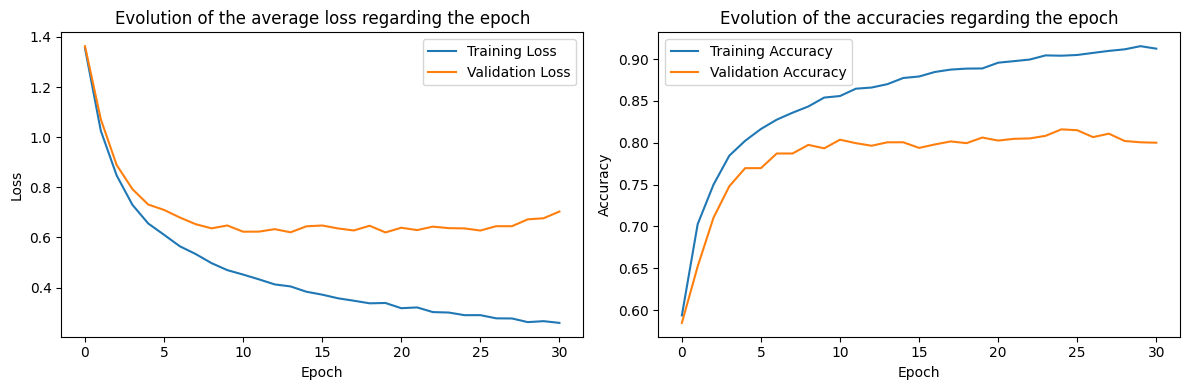

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(res["train_losses"], label="Training Loss")
plt.plot(res["val_losses"], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of the average loss regarding the epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(res["train_accuracies"], label='Training Accuracy')
plt.plot(res["val_accuracies"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracies regarding the epoch')
plt.legend()

plt.tight_layout()

plt.show()

In [ ]:
model.load("model_params.pt")
model.predict(validg, batch_size=128, device='cpu')

# Grid Search

In [ ]:
import tqdm
from tqdm import tqdm
import numpy as np

params_grid = {"window_size": [3, 2],
               "char_embedding_size": [32, 64, 128],
               "word_embedding_size": [128, 256, 512],
               "epochs": [20],
               "patience": [2, 3],
               "batch_size": [64, 128],
               "learning_rate": [0.0001, 0.001, 0.01],
               "dropout_prob": [0.2, 0.3, 0.5]}


nb_iter = np.prod([len(params) for params in params_grid.values()])

# Grid search loop
with open('gridsearch.csv', 'w') as file:  # saving hyperparameters and corresponding accuracy into a csv file to retrieve best hyperparameters
  for hyperparams in tqdm(itertools.product(*params_grid.values()), total=nb_iter):
    window_size, char_embedding_size, word_embedding_size, epochs, patience, batch_size, learning_rate, dropout_prob = hyperparams

    print(f"\nGrid search iteration with parameters:")
    print(f"Window Size: {window_size}, Char Embedding Dim: {char_embedding_size}, Word Embedding Dim: {word_embedding_size}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Patience: {patience}, dropout_prob: {dropout_prob}")

    model = LanguageIdentifier(traing, window_size, char_embedding_size, word_embedding_size, dropout_prob)
    res = model.training_loop(traingenerator=traing, validgenerator=validg, epochs=epochs, patience=patience, batch_size=batch_size, learning_rate=learning_rate, print_training=False, device='cuda')
    val_accuracy = res['val_accuracies'][-1]
    print(f"Last val accuracy: {val_accuracy}")
    print(window_size, char_embedding_size, word_embedding_size, batch_size, learning_rate, patience, dropout_prob, val_accuracy, file=file, sep="\t")

  0%|          | 0/648 [00:00<?, ?it/s]


Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


  0%|          | 1/648 [00:22<4:06:59, 22.91s/it]

Last val accuracy: 0.7187017001545595

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


  0%|          | 2/648 [00:33<2:51:27, 15.92s/it]

Last val accuracy: 0.708397733127254

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


  0%|          | 3/648 [00:44<2:25:56, 13.58s/it]

Last val accuracy: 0.6929417825862957

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


  1%|          | 4/648 [00:55<2:12:06, 12.31s/it]

Last val accuracy: 0.7913446676970634

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


  1%|          | 5/648 [01:06<2:07:45, 11.92s/it]

Last val accuracy: 0.7985574446161773

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


  1%|          | 6/648 [01:16<2:02:36, 11.46s/it]

Last val accuracy: 0.7805255023183926

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


  1%|          | 7/648 [01:27<1:59:43, 11.21s/it]

preceding loss: 0.7747760645204014, current loss on valid set: 0.7825956854728922
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7800103039670273

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


  1%|          | 8/648 [01:35<1:49:07, 10.23s/it]

preceding loss: 0.8409132947844844, current loss on valid set: 0.8539253314055743
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7557959814528593

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


  1%|▏         | 9/648 [01:45<1:46:56, 10.04s/it]

preceding loss: 0.8376163603557695, current loss on valid set: 0.8475844504371766
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7393096342091705

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


  2%|▏         | 10/648 [01:51<1:32:30,  8.70s/it]

Last val accuracy: 0.6919113858835652

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


  2%|▏         | 11/648 [01:57<1:24:13,  7.93s/it]

Last val accuracy: 0.6846986089644513

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


  2%|▏         | 12/648 [02:02<1:16:58,  7.26s/it]

Last val accuracy: 0.657908294693457

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


  2%|▏         | 13/648 [02:09<1:13:48,  6.97s/it]

Last val accuracy: 0.7995878413189078

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


  2%|▏         | 14/648 [02:14<1:09:42,  6.60s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


  2%|▏         | 15/648 [02:21<1:08:28,  6.49s/it]

Last val accuracy: 0.7851622874806801

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


  2%|▏         | 16/648 [02:25<1:02:17,  5.91s/it]

preceding loss: 0.7090366978663951, current loss on valid set: 0.7422856262419373
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7877382792375064

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


  3%|▎         | 17/648 [02:28<51:38,  4.91s/it]  

preceding loss: 0.8049364471808076, current loss on valid set: 0.8230201476253569
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7454920144255538

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


  3%|▎         | 18/648 [02:30<44:09,  4.21s/it]

preceding loss: 0.8459906973876059, current loss on valid set: 0.958624305902049
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


  3%|▎         | 19/648 [02:41<1:04:05,  6.11s/it]

Last val accuracy: 0.7310664605873262

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


  3%|▎         | 20/648 [02:52<1:18:09,  7.47s/it]

Last val accuracy: 0.7264296754250387

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


  3%|▎         | 21/648 [03:02<1:28:06,  8.43s/it]

Last val accuracy: 0.6919113858835652

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


  3%|▎         | 22/648 [03:13<1:35:01,  9.11s/it]

Last val accuracy: 0.8057702215352911

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


  4%|▎         | 23/648 [03:24<1:39:53,  9.59s/it]

Last val accuracy: 0.8016486347243689

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


  4%|▎         | 24/648 [03:35<1:43:34,  9.96s/it]

Last val accuracy: 0.7784647089129315

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


  4%|▍         | 25/648 [03:45<1:45:30, 10.16s/it]

Last val accuracy: 0.7825862957238536

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


  4%|▍         | 26/648 [03:55<1:45:45, 10.20s/it]

Last val accuracy: 0.762493560020608

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


  4%|▍         | 27/648 [04:06<1:47:08, 10.35s/it]

Last val accuracy: 0.7449768160741885

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


  4%|▍         | 28/648 [04:12<1:34:21,  9.13s/it]

Last val accuracy: 0.6846986089644513

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


  4%|▍         | 29/648 [04:18<1:23:23,  8.08s/it]

Last val accuracy: 0.6883049974240082

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


  5%|▍         | 30/648 [04:24<1:17:54,  7.56s/it]

Last val accuracy: 0.6646058732612056

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


  5%|▍         | 31/648 [04:30<1:11:52,  6.99s/it]

Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


  5%|▍         | 32/648 [04:36<1:09:36,  6.78s/it]

Last val accuracy: 0.7964966512107161

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


  5%|▌         | 33/648 [04:42<1:06:07,  6.45s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


  5%|▌         | 34/648 [04:45<55:35,  5.43s/it]  

preceding loss: 0.8735938938334584, current loss on valid set: 1.0997494544135407
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7223080886141164

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


  5%|▌         | 35/648 [04:51<57:26,  5.62s/it]

Last val accuracy: 0.7841318907779495

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


  6%|▌         | 36/648 [04:57<57:34,  5.65s/it]

Last val accuracy: 0.7702215352910871

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


  6%|▌         | 37/648 [05:08<1:13:03,  7.17s/it]

Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


  6%|▌         | 38/648 [05:18<1:23:58,  8.26s/it]

Last val accuracy: 0.740340030911901

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


  6%|▌         | 39/648 [05:29<1:31:42,  9.04s/it]

Last val accuracy: 0.7156105100463679

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


  6%|▌         | 40/648 [05:40<1:36:44,  9.55s/it]

Last val accuracy: 0.8088614116434827

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


  6%|▋         | 41/648 [05:51<1:40:15,  9.91s/it]

Last val accuracy: 0.8047398248325606

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


  6%|▋         | 42/648 [05:57<1:30:03,  8.92s/it]

preceding loss: 0.6789496349951913, current loss on valid set: 0.6793302849175469
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.783101494075219

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


  7%|▋         | 43/648 [06:05<1:24:50,  8.41s/it]

preceding loss: 0.8114725610902233, current loss on valid set: 0.8237009551976958
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7511591962905718

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


  7%|▋         | 44/648 [06:15<1:31:48,  9.12s/it]

Last val accuracy: 0.783101494075219

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


  7%|▋         | 45/648 [06:21<1:21:01,  8.06s/it]

preceding loss: 0.87611299188387, current loss on valid set: 0.8878143485635519
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7444616177228233

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


  7%|▋         | 46/648 [06:27<1:15:43,  7.55s/it]

Last val accuracy: 0.7192168985059247

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


  7%|▋         | 47/648 [06:33<1:10:04,  7.00s/it]

Last val accuracy: 0.7058217413704276

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


  7%|▋         | 48/648 [06:39<1:08:03,  6.81s/it]

Last val accuracy: 0.6944873776403916

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


  8%|▊         | 49/648 [06:45<1:04:43,  6.48s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


  8%|▊         | 50/648 [06:51<1:04:08,  6.44s/it]

Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


  8%|▊         | 51/648 [06:57<1:02:01,  6.23s/it]

Last val accuracy: 0.794435857805255

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


  8%|▊         | 52/648 [07:01<54:46,  5.51s/it]  

preceding loss: 0.8815907443640754, current loss on valid set: 0.9685647613368928
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.753219989696033

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


  8%|▊         | 53/648 [07:03<44:20,  4.47s/it]

preceding loss: 1.1485404036939144, current loss on valid set: 1.3333103391341865
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7058217413704276

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


  8%|▊         | 54/648 [07:09<48:03,  4.85s/it]

preceding loss: 0.6887531066313386, current loss on valid set: 0.7008586262818426
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7934054611025245

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


  8%|▊         | 55/648 [07:20<1:05:47,  6.66s/it]

Last val accuracy: 0.7506439979392066

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


  9%|▊         | 56/648 [07:30<1:17:53,  7.90s/it]

Last val accuracy: 0.7454920144255538

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


  9%|▉         | 57/648 [07:41<1:26:29,  8.78s/it]

Last val accuracy: 0.7284904688304997

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


  9%|▉         | 58/648 [07:52<1:32:07,  9.37s/it]

Last val accuracy: 0.8104070066975786

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


  9%|▉         | 59/648 [08:03<1:36:09,  9.80s/it]

Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


  9%|▉         | 60/648 [08:14<1:38:41, 10.07s/it]

Last val accuracy: 0.8031942297784647

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


  9%|▉         | 61/648 [08:24<1:38:52, 10.11s/it]

Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 10%|▉         | 62/648 [08:34<1:40:17, 10.27s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 10%|▉         | 63/648 [08:45<1:41:36, 10.42s/it]

Last val accuracy: 0.7594023699124163

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 10%|▉         | 64/648 [08:52<1:29:31,  9.20s/it]

Last val accuracy: 0.7156105100463679

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 10%|█         | 65/648 [08:57<1:19:15,  8.16s/it]

Last val accuracy: 0.7187017001545595

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 10%|█         | 66/648 [09:04<1:13:49,  7.61s/it]

Last val accuracy: 0.6908809891808346

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 10%|█         | 67/648 [09:09<1:07:53,  7.01s/it]

Last val accuracy: 0.7995878413189078

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 10%|█         | 68/648 [09:15<1:05:41,  6.80s/it]

Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 11%|█         | 69/648 [09:21<1:02:17,  6.46s/it]

Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 11%|█         | 70/648 [09:25<55:59,  5.81s/it]  

preceding loss: 0.7796557284891605, current loss on valid set: 0.7868786372710019
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7753735188047398

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 11%|█         | 71/648 [09:31<56:12,  5.84s/it]

Last val accuracy: 0.7851622874806801

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 11%|█         | 72/648 [09:34<46:43,  4.87s/it]

preceding loss: 0.8624475607648492, current loss on valid set: 1.2496422552503645
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6950025759917569

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 11%|█▏        | 73/648 [09:45<1:03:22,  6.61s/it]

Last val accuracy: 0.7697063369397218

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 11%|█▏        | 74/648 [09:55<1:15:10,  7.86s/it]

Last val accuracy: 0.7712519319938176

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 12%|█▏        | 75/648 [10:06<1:23:09,  8.71s/it]

Last val accuracy: 0.7527047913446677

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 12%|█▏        | 76/648 [10:12<1:13:54,  7.75s/it]

preceding loss: 0.6603830529436949, current loss on valid set: 0.6724127016721233
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7913446676970634

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 12%|█▏        | 77/648 [10:21<1:17:42,  8.17s/it]

preceding loss: 0.6431096234028378, current loss on valid set: 0.6523157996876586
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.8073158165893869

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 12%|█▏        | 78/648 [10:31<1:24:30,  8.89s/it]

Last val accuracy: 0.8052550231839258

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 12%|█▏        | 79/648 [10:38<1:18:13,  8.25s/it]

preceding loss: 0.8933422874298788, current loss on valid set: 0.903652320465734
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7650695517774343

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 12%|█▏        | 80/648 [10:42<1:07:04,  7.08s/it]

preceding loss: 0.9261034475939889, current loss on valid set: 0.9343026522547007
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7506439979392066

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 12%|█▎        | 81/648 [10:53<1:17:14,  8.17s/it]

Last val accuracy: 0.753219989696033

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 13%|█▎        | 82/648 [10:59<1:11:31,  7.58s/it]

Last val accuracy: 0.73827923750644

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 13%|█▎        | 83/648 [11:06<1:08:55,  7.32s/it]

Last val accuracy: 0.7351880473982483

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 13%|█▎        | 84/648 [11:12<1:05:27,  6.96s/it]

Last val accuracy: 0.7217928902627512

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 13%|█▎        | 85/648 [11:16<57:46,  6.16s/it]  

preceding loss: 0.6415259838104248, current loss on valid set: 0.6539624275173992
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7980422462648119

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 13%|█▎        | 86/648 [11:23<57:40,  6.16s/it]

Last val accuracy: 0.8104070066975786

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 13%|█▎        | 87/648 [11:29<59:03,  6.32s/it]

Last val accuracy: 0.8011334363730036

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 14%|█▎        | 88/648 [11:33<50:50,  5.45s/it]

preceding loss: 0.9328651111572981, current loss on valid set: 1.2032868744572625
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7485832045337455

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 14%|█▎        | 89/648 [11:36<44:13,  4.75s/it]

preceding loss: 0.8112556296400726, current loss on valid set: 1.2124345027841628
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7315816589386914

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 14%|█▍        | 90/648 [11:40<42:31,  4.57s/it]

preceding loss: 0.8084975552046672, current loss on valid set: 0.92211305629462
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7490984028851108

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 14%|█▍        | 91/648 [11:50<58:00,  6.25s/it]

Last val accuracy: 0.7619783616692427

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 14%|█▍        | 92/648 [12:01<1:10:02,  7.56s/it]

Last val accuracy: 0.7722823286965482

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 14%|█▍        | 93/648 [12:11<1:18:22,  8.47s/it]

Last val accuracy: 0.7521895929933025

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 15%|█▍        | 94/648 [12:21<1:22:16,  8.91s/it]

preceding loss: 0.6835120583493863, current loss on valid set: 0.6921934890410593
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7939206594538898

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 15%|█▍        | 95/648 [12:32<1:27:20,  9.48s/it]

Last val accuracy: 0.8124678001030397

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 15%|█▍        | 96/648 [12:43<1:30:32,  9.84s/it]

Last val accuracy: 0.8088614116434827

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 15%|█▍        | 97/648 [12:53<1:32:29, 10.07s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 15%|█▌        | 98/648 [13:02<1:27:59,  9.60s/it]

preceding loss: 0.8623324282948048, current loss on valid set: 0.8973132953528435
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.762493560020608

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 15%|█▌        | 99/648 [13:13<1:30:29,  9.89s/it]

Last val accuracy: 0.7609479649665121

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 15%|█▌        | 100/648 [13:19<1:21:30,  8.93s/it]

Last val accuracy: 0.740340030911901

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 16%|█▌        | 101/648 [13:25<1:13:52,  8.10s/it]

Last val accuracy: 0.7444616177228233

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 16%|█▌        | 102/648 [13:32<1:09:51,  7.68s/it]

Last val accuracy: 0.714064914992272

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 16%|█▌        | 103/648 [13:38<1:05:22,  7.20s/it]

Last val accuracy: 0.8073158165893869

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 16%|█▌        | 104/648 [13:45<1:03:39,  7.02s/it]

Last val accuracy: 0.8109222050489439

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 16%|█▌        | 105/648 [13:51<1:01:10,  6.76s/it]

Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 16%|█▋        | 106/648 [13:56<55:37,  6.16s/it]  

preceding loss: 0.835612335242331, current loss on valid set: 0.8848155678715557
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.773827923750644

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 17%|█▋        | 107/648 [14:02<55:45,  6.18s/it]

Last val accuracy: 0.788768675940237

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 17%|█▋        | 108/648 [14:06<50:54,  5.66s/it]

preceding loss: 0.845387915847823, current loss on valid set: 1.23793840338476
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7042761463163318

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 17%|█▋        | 109/648 [14:16<1:02:46,  6.99s/it]

Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 17%|█▋        | 110/648 [14:27<1:11:35,  7.98s/it]

Last val accuracy: 0.7449768160741885

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 17%|█▋        | 111/648 [14:37<1:18:03,  8.72s/it]

Last val accuracy: 0.7284904688304997

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 17%|█▋        | 112/648 [14:45<1:15:58,  8.50s/it]

preceding loss: 0.6586539657005379, current loss on valid set: 0.6810635387777321
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 17%|█▋        | 113/648 [14:56<1:21:23,  9.13s/it]

Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 18%|█▊        | 114/648 [15:06<1:24:59,  9.55s/it]

Last val accuracy: 0.7913446676970634

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 18%|█▊        | 115/648 [15:16<1:26:01,  9.68s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 18%|█▊        | 116/648 [15:22<1:16:22,  8.61s/it]

preceding loss: 0.8982747889334156, current loss on valid set: 0.9475061138791423
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7192168985059247

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 18%|█▊        | 117/648 [15:26<1:04:01,  7.23s/it]

preceding loss: 1.0073282456686419, current loss on valid set: 1.0099930968736448
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7011849562081401

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 18%|█▊        | 118/648 [15:33<1:01:07,  6.92s/it]

Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 18%|█▊        | 119/648 [15:38<57:30,  6.52s/it]  

Last val accuracy: 0.714064914992272

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 19%|█▊        | 120/648 [15:44<56:13,  6.39s/it]

Last val accuracy: 0.7022153529108707

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 19%|█▊        | 121/648 [15:50<54:00,  6.15s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 19%|█▉        | 122/648 [15:56<54:06,  6.17s/it]

Last val accuracy: 0.7964966512107161

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 19%|█▉        | 123/648 [16:02<52:21,  5.98s/it]

Last val accuracy: 0.7851622874806801

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 19%|█▉        | 124/648 [16:03<41:06,  4.71s/it]

preceding loss: 1.040743827354163, current loss on valid set: 1.1403528389055282
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7207624935600206

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 19%|█▉        | 125/648 [16:05<31:44,  3.64s/it]

preceding loss: 1.1409613834694028, current loss on valid set: 1.3312437934800982
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6501803194229778

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 19%|█▉        | 126/648 [16:09<34:04,  3.92s/it]

preceding loss: 0.7565830354578793, current loss on valid set: 0.857257419032976
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.743946419371458

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 20%|█▉        | 127/648 [16:20<51:17,  5.91s/it]

Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 20%|█▉        | 128/648 [16:30<1:02:13,  7.18s/it]

Last val accuracy: 0.7516743946419372

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 20%|█▉        | 129/648 [16:40<1:10:11,  8.12s/it]

Last val accuracy: 0.7279752704791345

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 20%|██        | 130/648 [16:51<1:16:14,  8.83s/it]

Last val accuracy: 0.7990726429675425

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 20%|██        | 131/648 [17:01<1:20:17,  9.32s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 20%|██        | 132/648 [17:11<1:23:04,  9.66s/it]

Last val accuracy: 0.7918598660484286

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 21%|██        | 133/648 [17:22<1:25:08,  9.92s/it]

Last val accuracy: 0.7779495105615662

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 21%|██        | 134/648 [17:32<1:25:07,  9.94s/it]

preceding loss: 0.8168895052325341, current loss on valid set: 0.8210527801345433
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 21%|██        | 135/648 [17:42<1:25:23,  9.99s/it]

Last val accuracy: 0.7398248325605358

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 21%|██        | 136/648 [17:48<1:15:03,  8.80s/it]

Last val accuracy: 0.729005667181865

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 21%|██        | 137/648 [17:54<1:06:37,  7.82s/it]

Last val accuracy: 0.7217928902627512

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 21%|██▏       | 138/648 [18:00<1:02:13,  7.32s/it]

Last val accuracy: 0.6991241628026791

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 21%|██▏       | 139/648 [18:05<57:41,  6.80s/it]  

Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 22%|██▏       | 140/648 [18:11<55:46,  6.59s/it]

Last val accuracy: 0.8011334363730036

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 22%|██▏       | 141/648 [18:17<53:01,  6.28s/it]

Last val accuracy: 0.788768675940237

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 22%|██▏       | 142/648 [18:22<49:46,  5.90s/it]

preceding loss: 0.8423660099506378, current loss on valid set: 0.8680198839865625
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 22%|██▏       | 143/648 [18:28<49:27,  5.88s/it]

Last val accuracy: 0.7758887171561051

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 22%|██▏       | 144/648 [18:34<50:11,  5.97s/it]

Last val accuracy: 0.7630087583719732

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 22%|██▏       | 145/648 [18:44<1:00:48,  7.25s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 23%|██▎       | 146/648 [18:54<1:07:03,  8.01s/it]

Last val accuracy: 0.7671303451828955

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 23%|██▎       | 147/648 [19:04<1:12:40,  8.70s/it]

Last val accuracy: 0.753219989696033

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 23%|██▎       | 148/648 [19:10<1:05:39,  7.88s/it]

preceding loss: 0.6769634910048016, current loss on valid set: 0.6770050992528277
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7841318907779495

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 23%|██▎       | 149/648 [19:16<59:28,  7.15s/it]  

preceding loss: 0.6566681565055924, current loss on valid set: 0.6749751265010526
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 23%|██▎       | 150/648 [19:23<59:43,  7.20s/it]

preceding loss: 0.6658855764375579, current loss on valid set: 0.6696654728824093
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 23%|██▎       | 151/648 [19:33<1:05:00,  7.85s/it]

preceding loss: 0.8270440758957017, current loss on valid set: 0.8666573746069786
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7702215352910871

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 23%|██▎       | 152/648 [19:39<1:02:25,  7.55s/it]

preceding loss: 0.8541682494143324, current loss on valid set: 0.901847089130071
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7429160226687275

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 24%|██▎       | 153/648 [19:45<58:14,  7.06s/it]  

preceding loss: 0.9359584344971564, current loss on valid set: 0.9381911881989048
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7202472952086554

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 24%|██▍       | 154/648 [19:51<54:09,  6.58s/it]

Last val accuracy: 0.7547655847501288

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 24%|██▍       | 155/648 [19:57<52:56,  6.44s/it]

Last val accuracy: 0.7501287995878413

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 24%|██▍       | 156/648 [20:02<50:33,  6.17s/it]

Last val accuracy: 0.7269448737764039

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 24%|██▍       | 157/648 [20:07<47:02,  5.75s/it]

preceding loss: 0.6093556130072102, current loss on valid set: 0.6321177687495947
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 24%|██▍       | 158/648 [20:13<46:58,  5.75s/it]

preceding loss: 0.6051806315081194, current loss on valid set: 0.6059575270628557
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.8134981968057702

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 25%|██▍       | 159/648 [20:18<46:16,  5.68s/it]

preceding loss: 0.6188687265384942, current loss on valid set: 0.6313371420837939
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 25%|██▍       | 160/648 [20:20<35:41,  4.39s/it]

preceding loss: 1.482949555851519, current loss on valid set: 1.57415880728513
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6543019062339

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 25%|██▍       | 161/648 [20:21<28:19,  3.49s/it]

preceding loss: 1.3602423733100295, current loss on valid set: 1.5259047150611877
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6491499227202473

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 25%|██▌       | 162/648 [20:23<24:00,  2.96s/it]

preceding loss: 1.0530582279898226, current loss on valid set: 1.4874585401266813
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6496651210716126

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 25%|██▌       | 163/648 [20:33<41:43,  5.16s/it]

Last val accuracy: 0.783101494075219

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 25%|██▌       | 164/648 [20:43<52:35,  6.52s/it]

Last val accuracy: 0.7733127253992788

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 25%|██▌       | 165/648 [20:53<1:01:48,  7.68s/it]

Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 26%|██▌       | 166/648 [21:04<1:08:44,  8.56s/it]

Last val accuracy: 0.7913446676970634

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 26%|██▌       | 167/648 [21:13<1:10:23,  8.78s/it]

preceding loss: 0.6580611449936705, current loss on valid set: 0.6662434721065145
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 26%|██▌       | 168/648 [21:24<1:14:00,  9.25s/it]

Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 26%|██▌       | 169/648 [21:30<1:07:06,  8.41s/it]

preceding loss: 1.0872908289874754, current loss on valid set: 1.9367274464138093
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6589386913961875

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 26%|██▌       | 170/648 [21:38<1:06:50,  8.39s/it]

preceding loss: 0.8165478727990582, current loss on valid set: 0.8220525167642101
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7697063369397218

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 26%|██▋       | 171/648 [21:49<1:11:01,  8.93s/it]

Last val accuracy: 0.7429160226687275

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 27%|██▋       | 172/648 [21:54<1:02:40,  7.90s/it]

Last val accuracy: 0.7501287995878413

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 27%|██▋       | 173/648 [22:00<58:12,  7.35s/it]  

Last val accuracy: 0.743946419371458

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 27%|██▋       | 174/648 [22:06<53:32,  6.78s/it]

Last val accuracy: 0.7367336424523442

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 27%|██▋       | 175/648 [22:12<51:43,  6.56s/it]

preceding loss: 0.6253984711947851, current loss on valid set: 0.6387604434858076
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7964966512107161

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 27%|██▋       | 176/648 [22:17<48:56,  6.22s/it]

Last val accuracy: 0.8098918083462133

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 27%|██▋       | 177/648 [22:23<48:22,  6.16s/it]

Last val accuracy: 0.8006182380216383

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 27%|██▋       | 178/648 [22:28<44:46,  5.72s/it]

preceding loss: 0.8176398791838437, current loss on valid set: 0.8203597525134683
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 28%|██▊       | 179/648 [22:32<41:32,  5.32s/it]

preceding loss: 0.8089133086614311, current loss on valid set: 1.1187379828188568
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7212776919113859

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 28%|██▊       | 180/648 [22:35<36:41,  4.71s/it]

preceding loss: 0.9011534908786416, current loss on valid set: 0.9414841365069151
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7310664605873262

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 28%|██▊       | 181/648 [22:46<49:18,  6.33s/it]

Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 28%|██▊       | 182/648 [22:55<57:08,  7.36s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 28%|██▊       | 183/648 [23:05<1:03:30,  8.20s/it]

Last val accuracy: 0.7753735188047398

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 28%|██▊       | 184/648 [23:13<1:01:12,  7.92s/it]

preceding loss: 0.6618478885821758, current loss on valid set: 0.6946087397574898
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7954662545079856

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 29%|██▊       | 185/648 [23:19<57:19,  7.43s/it]  

preceding loss: 0.6850677467882633, current loss on valid set: 0.6929639449883853
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7934054611025245

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 29%|██▊       | 186/648 [23:29<1:03:28,  8.24s/it]

Last val accuracy: 0.8134981968057702

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 29%|██▉       | 187/648 [23:39<1:07:33,  8.79s/it]

Last val accuracy: 0.7557959814528593

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 29%|██▉       | 188/648 [23:41<51:35,  6.73s/it]  

preceding loss: 1.9203604310750961, current loss on valid set: 2.9070358176625546
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6146316331787738

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 29%|██▉       | 189/648 [23:47<50:27,  6.60s/it]

preceding loss: 0.973785229327698, current loss on valid set: 0.9827724734261152
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 29%|██▉       | 190/648 [23:53<48:13,  6.32s/it]

Last val accuracy: 0.7815558990211231

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 29%|██▉       | 191/648 [23:59<47:48,  6.28s/it]

Last val accuracy: 0.7702215352910871

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 30%|██▉       | 192/648 [24:05<46:13,  6.08s/it]

Last val accuracy: 0.7609479649665121

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 30%|██▉       | 193/648 [24:09<42:09,  5.56s/it]

preceding loss: 0.6399601008743048, current loss on valid set: 0.6411462917458266
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 30%|██▉       | 194/648 [24:15<43:12,  5.71s/it]

Last val accuracy: 0.8155589902112313

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 30%|███       | 195/648 [24:21<43:10,  5.72s/it]

Last val accuracy: 0.8124678001030397

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 30%|███       | 196/648 [24:27<42:53,  5.69s/it]

preceding loss: 0.9147994627710432, current loss on valid set: 0.981736795976758
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7594023699124163

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 30%|███       | 197/648 [24:28<33:51,  4.51s/it]

preceding loss: 1.2051464864052832, current loss on valid set: 1.305956095457077
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7037609479649665

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 31%|███       | 198/648 [24:31<28:44,  3.83s/it]

preceding loss: 0.8870461811311543, current loss on valid set: 1.1350011602044106
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7171561051004637

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 31%|███       | 199/648 [24:41<42:53,  5.73s/it]

Last val accuracy: 0.794435857805255

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 31%|███       | 200/648 [24:51<52:35,  7.04s/it]

Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 31%|███       | 201/648 [25:01<59:28,  7.98s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 31%|███       | 202/648 [25:11<1:04:04,  8.62s/it]

Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 31%|███▏      | 203/648 [25:18<1:00:56,  8.22s/it]

preceding loss: 0.705851189191303, current loss on valid set: 0.7342279678991726
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7980422462648119

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 31%|███▏      | 204/648 [25:29<1:05:01,  8.79s/it]

Last val accuracy: 0.8129829984544049

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 32%|███▏      | 205/648 [25:35<59:05,  8.00s/it]  

preceding loss: 1.0465749764154035, current loss on valid set: 1.2752558041904722
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7413704276146317

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 32%|███▏      | 206/648 [25:39<51:11,  6.95s/it]

preceding loss: 1.1230163171046204, current loss on valid set: 1.6185120690253474
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6743946419371458

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 32%|███▏      | 207/648 [25:49<57:54,  7.88s/it]

Last val accuracy: 0.7161257083977332

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 32%|███▏      | 208/648 [25:55<52:48,  7.20s/it]

Last val accuracy: 0.779495105615662

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 32%|███▏      | 209/648 [26:01<50:23,  6.89s/it]

Last val accuracy: 0.773827923750644

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 32%|███▏      | 210/648 [26:07<47:33,  6.52s/it]

Last val accuracy: 0.7599175682637815

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 33%|███▎      | 211/648 [26:11<43:27,  5.97s/it]

preceding loss: 0.6290855188271962, current loss on valid set: 0.6543652229011059
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.8052550231839258

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 33%|███▎      | 212/648 [26:17<42:41,  5.88s/it]

Last val accuracy: 0.8186501803194229

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 33%|███▎      | 213/648 [26:23<42:51,  5.91s/it]

Last val accuracy: 0.8119526017516744

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 33%|███▎      | 214/648 [26:28<41:14,  5.70s/it]

preceding loss: 0.8351838156813756, current loss on valid set: 1.0347546731354669
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7619783616692427

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 33%|███▎      | 215/648 [26:34<41:08,  5.70s/it]

Last val accuracy: 0.7980422462648119

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 33%|███▎      | 216/648 [26:38<36:23,  5.05s/it]

preceding loss: 0.8146704179234803, current loss on valid set: 0.8855124819092453
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7563111798042246

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 33%|███▎      | 217/648 [26:48<47:49,  6.66s/it]

Last val accuracy: 0.7722823286965482

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 34%|███▎      | 218/648 [26:58<54:26,  7.60s/it]

Last val accuracy: 0.7686759402369913

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 34%|███▍      | 219/648 [27:08<1:00:42,  8.49s/it]

Last val accuracy: 0.7599175682637815

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 34%|███▍      | 220/648 [27:14<55:37,  7.80s/it]  

preceding loss: 0.7108059831924977, current loss on valid set: 0.7165845070755289
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7753735188047398

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 34%|███▍      | 221/648 [27:24<58:17,  8.19s/it]

preceding loss: 0.677074121491563, current loss on valid set: 0.6880353998032308
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7892838742916023

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 34%|███▍      | 222/648 [27:34<1:02:05,  8.75s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 34%|███▍      | 223/648 [27:38<52:53,  7.47s/it]  

preceding loss: 1.0196389986142036, current loss on valid set: 1.0696977976589435
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7063369397217929

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 35%|███▍      | 224/648 [27:41<44:08,  6.25s/it]

preceding loss: 1.0846365013670536, current loss on valid set: 1.0970560028668372
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6816074188562596

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 35%|███▍      | 225/648 [27:46<40:51,  5.80s/it]

preceding loss: 1.008609253552652, current loss on valid set: 1.0367562850156138
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6903657908294694

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 35%|███▍      | 226/648 [27:52<39:56,  5.68s/it]

Last val accuracy: 0.7542503863987635

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 35%|███▌      | 227/648 [27:57<40:08,  5.72s/it]

Last val accuracy: 0.753219989696033

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 35%|███▌      | 228/648 [28:03<39:27,  5.64s/it]

Last val accuracy: 0.7362184441009789

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 35%|███▌      | 229/648 [28:09<39:48,  5.70s/it]

Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 35%|███▌      | 230/648 [28:14<39:06,  5.61s/it]

Last val accuracy: 0.7841318907779495

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 36%|███▌      | 231/648 [28:20<39:33,  5.69s/it]

Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 36%|███▌      | 232/648 [28:21<29:54,  4.31s/it]

preceding loss: 1.483285159803927, current loss on valid set: 2.2407385422848165
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6032972694487377

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 36%|███▌      | 233/648 [28:24<26:28,  3.83s/it]

preceding loss: 1.0311093151103705, current loss on valid set: 1.32201884011738
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6738794435857806

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 36%|███▌      | 234/648 [28:29<28:40,  4.16s/it]

preceding loss: 0.8082095528952777, current loss on valid set: 0.8208608669228852
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7341576506955177

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 36%|███▋      | 235/648 [28:39<41:02,  5.96s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 36%|███▋      | 236/648 [28:49<49:58,  7.28s/it]

Last val accuracy: 0.7727975270479135

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 37%|███▋      | 237/648 [28:59<55:47,  8.15s/it]

Last val accuracy: 0.7501287995878413

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 37%|███▋      | 238/648 [29:08<55:45,  8.16s/it]

preceding loss: 0.6766654937978713, current loss on valid set: 0.6770857195219686
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7877382792375064

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 37%|███▋      | 239/648 [29:18<59:31,  8.73s/it]

Last val accuracy: 0.7934054611025245

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 37%|███▋      | 240/648 [29:28<1:02:31,  9.19s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 37%|███▋      | 241/648 [29:38<1:03:23,  9.35s/it]

preceding loss: 0.9031564558465635, current loss on valid set: 0.9316588830082647
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7269448737764039

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 37%|███▋      | 242/648 [29:48<1:04:24,  9.52s/it]

Last val accuracy: 0.7320968572900567

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 38%|███▊      | 243/648 [29:55<1:00:33,  8.97s/it]

preceding loss: 0.930395798337075, current loss on valid set: 0.9701436593407585
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7011849562081401

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 38%|███▊      | 244/648 [30:01<54:09,  8.04s/it]  

Last val accuracy: 0.7660999484801648

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 38%|███▊      | 245/648 [30:07<49:03,  7.30s/it]

Last val accuracy: 0.7547655847501288

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 38%|███▊      | 246/648 [30:13<45:56,  6.86s/it]

Last val accuracy: 0.7398248325605358

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 38%|███▊      | 247/648 [30:18<43:10,  6.46s/it]

Last val accuracy: 0.8026790314270994

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 38%|███▊      | 248/648 [30:22<37:48,  5.67s/it]

preceding loss: 0.6550053934333846, current loss on valid set: 0.6624123954679817
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 38%|███▊      | 249/648 [30:28<38:02,  5.72s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 39%|███▊      | 250/648 [30:33<37:25,  5.64s/it]

Last val accuracy: 0.7331272539927872

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 39%|███▊      | 251/648 [30:39<37:49,  5.72s/it]

Last val accuracy: 0.768160741885626

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 39%|███▉      | 252/648 [30:45<37:14,  5.64s/it]

Last val accuracy: 0.7413704276146317

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 39%|███▉      | 253/648 [30:55<45:52,  6.97s/it]

Last val accuracy: 0.7985574446161773

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 39%|███▉      | 254/648 [31:05<51:55,  7.91s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 39%|███▉      | 255/648 [31:15<55:57,  8.54s/it]

Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 40%|███▉      | 256/648 [31:21<51:23,  7.87s/it]

preceding loss: 0.6987770012309474, current loss on valid set: 0.708738032608263
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7964966512107161

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 40%|███▉      | 257/648 [31:31<55:01,  8.44s/it]

Last val accuracy: 0.8021638330757341

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 40%|███▉      | 258/648 [31:39<54:56,  8.45s/it]

preceding loss: 0.6538338379994515, current loss on valid set: 0.6554211195438139
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7964966512107161

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 40%|███▉      | 259/648 [31:43<45:38,  7.04s/it]

preceding loss: 1.24135749931297, current loss on valid set: 1.2491817121063509
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6759402369912416

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 40%|████      | 260/648 [31:48<41:15,  6.38s/it]

preceding loss: 0.9908314266752812, current loss on valid set: 0.9914458385638653
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7166409067490984

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 40%|████      | 261/648 [31:53<38:15,  5.93s/it]

preceding loss: 0.9426005364906404, current loss on valid set: 0.9595698281641929
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.71973209685729

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 40%|████      | 262/648 [31:59<38:20,  5.96s/it]

Last val accuracy: 0.7841318907779495

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 41%|████      | 263/648 [32:04<37:21,  5.82s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 41%|████      | 264/648 [32:10<37:31,  5.86s/it]

Last val accuracy: 0.7712519319938176

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 41%|████      | 265/648 [32:15<34:44,  5.44s/it]

preceding loss: 0.6416079423506744, current loss on valid set: 0.644628822512459
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 41%|████      | 266/648 [32:19<32:24,  5.09s/it]

preceding loss: 0.639110688236542, current loss on valid set: 0.6440377179533243
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7918598660484286

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 41%|████      | 267/648 [32:25<33:18,  5.25s/it]

Last val accuracy: 0.8068006182380216

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 41%|████▏     | 268/648 [32:26<25:23,  4.01s/it]

preceding loss: 1.9833090943284333, current loss on valid set: 1.9997579529881477
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6424523441524987

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 42%|████▏     | 269/648 [32:29<23:43,  3.76s/it]

preceding loss: 0.8836897949222475, current loss on valid set: 0.9895165823400021
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7357032457496137

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 42%|████▏     | 270/648 [32:33<24:57,  3.96s/it]

preceding loss: 0.8361050877720118, current loss on valid set: 0.8768662721849978
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 42%|████▏     | 271/648 [32:44<36:38,  5.83s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 42%|████▏     | 272/648 [32:54<44:40,  7.13s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 42%|████▏     | 273/648 [33:04<50:33,  8.09s/it]

Last val accuracy: 0.7810407006697578

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 42%|████▏     | 274/648 [33:12<49:17,  7.91s/it]

preceding loss: 0.743014199238631, current loss on valid set: 0.7571068972108825
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 42%|████▏     | 275/648 [33:22<53:56,  8.68s/it]

Last val accuracy: 0.8016486347243689

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 43%|████▎     | 276/648 [33:33<57:51,  9.33s/it]

Last val accuracy: 0.7995878413189078

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 43%|████▎     | 277/648 [33:44<1:00:20,  9.76s/it]

Last val accuracy: 0.7377640391550747

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 43%|████▎     | 278/648 [33:54<1:00:54,  9.88s/it]

Last val accuracy: 0.7557959814528593

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 43%|████▎     | 279/648 [34:00<53:57,  8.77s/it]  

preceding loss: 1.2468508310135333, current loss on valid set: 1.3720857247469886
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6810922205048944

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 43%|████▎     | 280/648 [34:06<47:59,  7.83s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 43%|████▎     | 281/648 [34:12<44:27,  7.27s/it]

Last val accuracy: 0.7743431221020093

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 44%|████▎     | 282/648 [34:17<41:20,  6.78s/it]

Last val accuracy: 0.7604327666151468

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 44%|████▎     | 283/648 [34:23<39:46,  6.54s/it]

Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 44%|████▍     | 284/648 [34:29<37:57,  6.26s/it]

Last val accuracy: 0.8088614116434827

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 44%|████▍     | 285/648 [34:35<37:18,  6.17s/it]

Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 44%|████▍     | 286/648 [34:40<36:13,  6.00s/it]

Last val accuracy: 0.764554353426069

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 44%|████▍     | 287/648 [34:46<36:13,  6.02s/it]

Last val accuracy: 0.7784647089129315

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 44%|████▍     | 288/648 [34:52<35:18,  5.89s/it]

Last val accuracy: 0.7753735188047398

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 45%|████▍     | 289/648 [35:02<42:58,  7.18s/it]

Last val accuracy: 0.8031942297784647

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 45%|████▍     | 290/648 [35:12<48:11,  8.08s/it]

Last val accuracy: 0.8042246264811953

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 45%|████▍     | 291/648 [35:22<51:44,  8.70s/it]

Last val accuracy: 0.7959814528593508

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 45%|████▌     | 292/648 [35:26<43:11,  7.28s/it]

preceding loss: 0.7638421098911955, current loss on valid set: 0.7650740536590738
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7810407006697578

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 45%|████▌     | 293/648 [35:34<42:53,  7.25s/it]

preceding loss: 0.7333609678091542, current loss on valid set: 0.7621344974444758
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 45%|████▌     | 294/648 [35:41<42:45,  7.25s/it]

preceding loss: 0.6870619175775398, current loss on valid set: 0.6930719612827224
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 46%|████▌     | 295/648 [35:51<47:21,  8.05s/it]

Last val accuracy: 0.7181865018031942

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 46%|████▌     | 296/648 [35:56<42:17,  7.21s/it]

preceding loss: 1.2762130795707625, current loss on valid set: 1.4378153663729467
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6991241628026791

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 46%|████▌     | 297/648 [35:59<34:43,  5.93s/it]

preceding loss: 1.2954848033766593, current loss on valid set: 2.809817460756148
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.5893869139618754

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 46%|████▌     | 298/648 [36:06<36:01,  6.18s/it]

Last val accuracy: 0.7990726429675425

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 46%|████▌     | 299/648 [36:12<36:18,  6.24s/it]

Last val accuracy: 0.7928902627511591

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 46%|████▋     | 300/648 [36:19<37:02,  6.39s/it]

Last val accuracy: 0.7784647089129315

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 46%|████▋     | 301/648 [36:23<33:03,  5.71s/it]

preceding loss: 0.656221723620547, current loss on valid set: 0.6963540650904179
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.80370942812983

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 47%|████▋     | 302/648 [36:27<29:40,  5.15s/it]

preceding loss: 0.6355512249283493, current loss on valid set: 0.662743974244222
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 47%|████▋     | 303/648 [36:29<25:10,  4.38s/it]

preceding loss: 0.6648600564803928, current loss on valid set: 0.6809064629487693
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 47%|████▋     | 304/648 [36:32<22:03,  3.85s/it]

preceding loss: 0.9983072215691209, current loss on valid set: 1.1132398210465908
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7614631633178773

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 47%|████▋     | 305/648 [36:34<18:42,  3.27s/it]

preceding loss: 1.5406316260341555, current loss on valid set: 1.65149509254843
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7022153529108707

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 47%|████▋     | 306/648 [36:40<22:55,  4.02s/it]

preceding loss: 0.8177993460558355, current loss on valid set: 0.8567640690598637
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7547655847501288

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 47%|████▋     | 307/648 [36:50<33:22,  5.87s/it]

Last val accuracy: 0.8098918083462133

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 48%|████▊     | 308/648 [37:00<40:07,  7.08s/it]

Last val accuracy: 0.8083462132921174

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 48%|████▊     | 309/648 [37:10<44:53,  7.94s/it]

Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 48%|████▊     | 310/648 [37:16<42:36,  7.56s/it]

preceding loss: 0.753532718025869, current loss on valid set: 0.7622610069811344
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7975270479134466

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 48%|████▊     | 311/648 [37:24<41:55,  7.46s/it]

preceding loss: 0.7339665118094173, current loss on valid set: 0.75687385759046
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7939206594538898

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 48%|████▊     | 312/648 [37:31<40:50,  7.29s/it]

preceding loss: 0.6809791353561224, current loss on valid set: 0.690303327095124
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7939206594538898

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 48%|████▊     | 313/648 [37:38<41:28,  7.43s/it]

preceding loss: 1.0967941864003097, current loss on valid set: 1.5135628398988517
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6898505924781041

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 48%|████▊     | 314/648 [37:48<45:47,  8.23s/it]

Last val accuracy: 0.7181865018031942

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 49%|████▊     | 315/648 [37:58<47:11,  8.50s/it]

preceding loss: 1.1625824232976283, current loss on valid set: 1.2424391850588783
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6970633693972179

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 49%|████▉     | 316/648 [38:04<43:36,  7.88s/it]

Last val accuracy: 0.7975270479134466

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 49%|████▉     | 317/648 [38:11<41:29,  7.52s/it]

Last val accuracy: 0.7949510561566203

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 49%|████▉     | 318/648 [38:17<39:31,  7.19s/it]

Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 49%|████▉     | 319/648 [38:21<34:29,  6.29s/it]

preceding loss: 0.6256114996504039, current loss on valid set: 0.6565300556831062
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.8057702215352911

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 49%|████▉     | 320/648 [38:26<31:24,  5.74s/it]

preceding loss: 0.6485387785360217, current loss on valid set: 0.652565476950258
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.8073158165893869

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 50%|████▉     | 321/648 [38:32<32:48,  6.02s/it]

Last val accuracy: 0.8098918083462133

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 50%|████▉     | 322/648 [38:39<33:22,  6.14s/it]

Last val accuracy: 0.7480680061823802

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 50%|████▉     | 323/648 [38:44<31:31,  5.82s/it]

preceding loss: 0.9308455355931073, current loss on valid set: 0.9712224354734644
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7604327666151468

Grid search iteration with parameters:
Window Size: 3, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 50%|█████     | 324/648 [38:47<27:41,  5.13s/it]

preceding loss: 0.9764983681961894, current loss on valid set: 1.2304246553685516
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7089129314786192

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 50%|█████     | 325/648 [38:58<35:57,  6.68s/it]

Last val accuracy: 0.7001545595054096

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 50%|█████     | 326/648 [39:08<41:38,  7.76s/it]

Last val accuracy: 0.6919113858835652

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 50%|█████     | 327/648 [39:18<45:35,  8.52s/it]

Last val accuracy: 0.6646058732612056

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 51%|█████     | 328/648 [39:29<48:17,  9.05s/it]

Last val accuracy: 0.788768675940237

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 51%|█████     | 329/648 [39:39<50:03,  9.42s/it]

Last val accuracy: 0.7800103039670273

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 51%|█████     | 330/648 [39:49<51:01,  9.63s/it]

Last val accuracy: 0.7691911385883565

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 51%|█████     | 331/648 [39:59<52:10,  9.87s/it]

Last val accuracy: 0.7516743946419372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 51%|█████     | 332/648 [40:10<52:43, 10.01s/it]

Last val accuracy: 0.7465224111282844

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 51%|█████▏    | 333/648 [40:20<52:53, 10.08s/it]

Last val accuracy: 0.734672849046883

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 52%|█████▏    | 334/648 [40:26<46:17,  8.84s/it]

Last val accuracy: 0.6501803194229778

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 52%|█████▏    | 335/648 [40:32<41:01,  7.86s/it]

Last val accuracy: 0.6357547655847501

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 52%|█████▏    | 336/648 [40:37<37:54,  7.29s/it]

Last val accuracy: 0.6202988150437918

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 52%|█████▏    | 337/648 [40:43<35:04,  6.77s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 52%|█████▏    | 338/648 [40:49<33:40,  6.52s/it]

Last val accuracy: 0.7727975270479135

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 52%|█████▏    | 339/648 [40:55<32:14,  6.26s/it]

Last val accuracy: 0.7655847501287996

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 52%|█████▏    | 340/648 [40:58<27:39,  5.39s/it]

preceding loss: 0.7882999735884368, current loss on valid set: 0.7994100814685225
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7454920144255538

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 53%|█████▎    | 341/648 [41:01<24:14,  4.74s/it]

preceding loss: 0.8538170526735485, current loss on valid set: 0.9028699861373752
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7187017001545595

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 53%|█████▎    | 342/648 [41:04<20:46,  4.07s/it]

preceding loss: 0.8587525235489011, current loss on valid set: 0.8683029422536492
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7223080886141164

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 53%|█████▎    | 343/648 [41:14<30:09,  5.93s/it]

Last val accuracy: 0.6893353941267388

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 53%|█████▎    | 344/648 [41:24<36:43,  7.25s/it]

Last val accuracy: 0.6852138073158166

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 53%|█████▎    | 345/648 [41:35<41:07,  8.14s/it]

Last val accuracy: 0.6558475012879958

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 53%|█████▎    | 346/648 [41:45<44:06,  8.76s/it]

Last val accuracy: 0.7851622874806801

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 54%|█████▎    | 347/648 [41:55<46:18,  9.23s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 54%|█████▎    | 348/648 [42:05<47:05,  9.42s/it]

Last val accuracy: 0.7697063369397218

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 54%|█████▍    | 349/648 [42:15<48:11,  9.67s/it]

Last val accuracy: 0.7573415765069552

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 54%|█████▍    | 350/648 [42:25<48:56,  9.85s/it]

Last val accuracy: 0.7434312210200927

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 54%|█████▍    | 351/648 [42:36<49:18,  9.96s/it]

Last val accuracy: 0.7377640391550747

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 54%|█████▍    | 352/648 [42:42<43:15,  8.77s/it]

Last val accuracy: 0.6481195260175168

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 54%|█████▍    | 353/648 [42:47<38:24,  7.81s/it]

Last val accuracy: 0.6512107161257084

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 55%|█████▍    | 354/648 [42:53<35:32,  7.25s/it]

Last val accuracy: 0.6311179804224627

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 55%|█████▍    | 355/648 [42:59<32:56,  6.75s/it]

Last val accuracy: 0.7691911385883565

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 55%|█████▍    | 356/648 [43:05<31:35,  6.49s/it]

Last val accuracy: 0.7748583204533745

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 55%|█████▌    | 357/648 [43:10<30:08,  6.22s/it]

Last val accuracy: 0.7686759402369913

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 55%|█████▌    | 358/648 [43:14<26:15,  5.43s/it]

preceding loss: 0.8664492291864008, current loss on valid set: 0.8833919684402645
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7228232869654817

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 55%|█████▌    | 359/648 [43:19<26:27,  5.49s/it]

Last val accuracy: 0.7697063369397218

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 56%|█████▌    | 360/648 [43:25<26:59,  5.62s/it]

Last val accuracy: 0.7490984028851108

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 56%|█████▌    | 361/648 [43:35<32:49,  6.86s/it]

Last val accuracy: 0.7398248325605358

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 56%|█████▌    | 362/648 [43:45<37:17,  7.82s/it]

Last val accuracy: 0.7166409067490984

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 56%|█████▌    | 363/648 [43:55<40:25,  8.51s/it]

Last val accuracy: 0.708397733127254

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 56%|█████▌    | 364/648 [44:05<42:36,  9.00s/it]

preceding loss: 0.6584640790618235, current loss on valid set: 0.6655270010232925
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7954662545079856

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 56%|█████▋    | 365/648 [44:16<43:58,  9.32s/it]

Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 56%|█████▋    | 366/648 [44:26<44:57,  9.57s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 57%|█████▋    | 367/648 [44:32<39:36,  8.46s/it]

preceding loss: 0.8496952694990942, current loss on valid set: 0.9059295854981868
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7367336424523442

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 57%|█████▋    | 368/648 [44:36<34:10,  7.32s/it]

preceding loss: 0.8963195020633359, current loss on valid set: 0.9263345463381659
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.729005667181865

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 57%|█████▋    | 369/648 [44:42<31:17,  6.73s/it]

preceding loss: 0.8965232679920812, current loss on valid set: 0.9166102385328662
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7171561051004637

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 57%|█████▋    | 370/648 [44:47<29:57,  6.47s/it]

Last val accuracy: 0.6862442040185471

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 57%|█████▋    | 371/648 [44:53<28:27,  6.17s/it]

Last val accuracy: 0.6913961875321999

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 57%|█████▋    | 372/648 [44:59<28:07,  6.11s/it]

Last val accuracy: 0.6594538897475528

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 58%|█████▊    | 373/648 [45:04<27:05,  5.91s/it]

Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 58%|█████▊    | 374/648 [45:10<26:56,  5.90s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 58%|█████▊    | 375/648 [45:16<26:11,  5.76s/it]

Last val accuracy: 0.7779495105615662

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 58%|█████▊    | 376/648 [45:21<25:47,  5.69s/it]

preceding loss: 0.7144991133827716, current loss on valid set: 0.7232732279226184
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 58%|█████▊    | 377/648 [45:25<23:34,  5.22s/it]

preceding loss: 0.8251445959322155, current loss on valid set: 0.9104807577095926
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7511591962905718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 58%|█████▊    | 378/648 [45:31<24:04,  5.35s/it]

preceding loss: 0.7628853865899146, current loss on valid set: 0.7773458492010832
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.755280783101494

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 58%|█████▊    | 379/648 [45:41<30:10,  6.73s/it]

Last val accuracy: 0.7181865018031942

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 59%|█████▊    | 380/648 [45:51<34:22,  7.70s/it]

Last val accuracy: 0.717671303451829

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 59%|█████▉    | 381/648 [46:01<37:28,  8.42s/it]

Last val accuracy: 0.6955177743431221

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 59%|█████▉    | 382/648 [46:11<39:37,  8.94s/it]

Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 59%|█████▉    | 383/648 [46:21<41:03,  9.30s/it]

Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 59%|█████▉    | 384/648 [46:31<41:59,  9.54s/it]

Last val accuracy: 0.7805255023183926

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 59%|█████▉    | 385/648 [46:41<42:35,  9.72s/it]

Last val accuracy: 0.7691911385883565

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 60%|█████▉    | 386/648 [46:52<42:57,  9.84s/it]

Last val accuracy: 0.749613601236476

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 60%|█████▉    | 387/648 [47:02<43:09,  9.92s/it]

Last val accuracy: 0.7449768160741885

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 60%|█████▉    | 388/648 [47:07<37:15,  8.60s/it]

Last val accuracy: 0.6857290056671819

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 60%|██████    | 389/648 [47:13<33:38,  7.79s/it]

Last val accuracy: 0.6841834106130861

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 60%|██████    | 390/648 [47:19<30:31,  7.10s/it]

Last val accuracy: 0.6599690880989181

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 60%|██████    | 391/648 [47:24<28:51,  6.74s/it]

Last val accuracy: 0.7939206594538898

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 60%|██████    | 392/648 [47:30<27:09,  6.36s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 61%|██████    | 393/648 [47:36<26:32,  6.24s/it]

Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 61%|██████    | 394/648 [47:41<25:28,  6.02s/it]

Last val accuracy: 0.7764039155074703

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 61%|██████    | 395/648 [47:46<24:11,  5.74s/it]

preceding loss: 0.7786411829292774, current loss on valid set: 0.8338917607907206
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.768160741885626

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 61%|██████    | 396/648 [47:52<23:18,  5.55s/it]

preceding loss: 0.7509429468773305, current loss on valid set: 0.7563668340444565
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7707367336424523

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 61%|██████▏   | 397/648 [48:02<29:15,  7.00s/it]

Last val accuracy: 0.755280783101494

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 61%|██████▏   | 398/648 [48:12<33:01,  7.93s/it]

Last val accuracy: 0.747552807831015

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 62%|██████▏   | 399/648 [48:22<35:33,  8.57s/it]

Last val accuracy: 0.7284904688304997

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 62%|██████▏   | 400/648 [48:32<37:23,  9.05s/it]

preceding loss: 0.6958236569358457, current loss on valid set: 0.7020647953594884
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7856774858320453

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 62%|██████▏   | 401/648 [48:42<38:20,  9.32s/it]

Last val accuracy: 0.80370942812983

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 62%|██████▏   | 402/648 [48:50<36:25,  8.89s/it]

preceding loss: 0.6823897767932184, current loss on valid set: 0.6869098880598622
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7815558990211231

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 62%|██████▏   | 403/648 [48:58<35:12,  8.62s/it]

preceding loss: 0.9237245435435926, current loss on valid set: 1.0256835753398557
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.734672849046883

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 62%|██████▏   | 404/648 [49:06<34:24,  8.46s/it]

preceding loss: 0.8368747328077594, current loss on valid set: 0.8555012692607218
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 62%|██████▎   | 405/648 [49:10<28:45,  7.10s/it]

preceding loss: 0.9803199128758523, current loss on valid set: 0.9907641748507177
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.708397733127254

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 63%|██████▎   | 406/648 [49:16<26:56,  6.68s/it]

Last val accuracy: 0.7202472952086554

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 63%|██████▎   | 407/648 [49:22<25:51,  6.44s/it]

Last val accuracy: 0.7166409067490984

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 63%|██████▎   | 408/648 [49:27<24:48,  6.20s/it]

Last val accuracy: 0.6980937660999484

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 63%|██████▎   | 409/648 [49:33<23:49,  5.98s/it]

preceding loss: 0.6211044108495116, current loss on valid set: 0.6314590722322464
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 63%|██████▎   | 410/648 [49:38<23:19,  5.88s/it]

Last val accuracy: 0.7975270479134466

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 63%|██████▎   | 411/648 [49:44<23:08,  5.86s/it]

Last val accuracy: 0.7985574446161773

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 64%|██████▎   | 412/648 [49:48<20:43,  5.27s/it]

preceding loss: 0.8098133653402328, current loss on valid set: 0.9091548800934106
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7413704276146317

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 64%|██████▎   | 413/648 [49:50<17:00,  4.34s/it]

preceding loss: 1.0266294605098665, current loss on valid set: 1.0274015592876822
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7078825347758887

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 64%|██████▍   | 414/648 [49:54<15:45,  4.04s/it]

preceding loss: 0.8578857271932065, current loss on valid set: 0.8924472306389362
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 64%|██████▍   | 415/648 [50:04<22:40,  5.84s/it]

Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 64%|██████▍   | 416/648 [50:14<27:36,  7.14s/it]

Last val accuracy: 0.749613601236476

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 64%|██████▍   | 417/648 [50:24<30:35,  7.94s/it]

Last val accuracy: 0.7253992787223081

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 65%|██████▍   | 418/648 [50:33<31:47,  8.29s/it]

preceding loss: 0.6574109703182213, current loss on valid set: 0.6746442434528181
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 65%|██████▍   | 419/648 [50:43<33:41,  8.83s/it]

preceding loss: 0.6766423825775424, current loss on valid set: 0.6831131311914613
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7825862957238536

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 65%|██████▍   | 420/648 [50:53<35:01,  9.22s/it]

Last val accuracy: 0.8057702215352911

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 65%|██████▍   | 421/648 [51:03<35:52,  9.48s/it]

Last val accuracy: 0.7599175682637815

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 65%|██████▌   | 422/648 [51:10<33:09,  8.80s/it]

preceding loss: 0.8878436066931293, current loss on valid set: 0.9016096933234122
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7506439979392066

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 65%|██████▌   | 423/648 [51:20<34:04,  9.09s/it]

Last val accuracy: 0.7331272539927872

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 65%|██████▌   | 424/648 [51:26<30:28,  8.16s/it]

Last val accuracy: 0.7253992787223081

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 66%|██████▌   | 425/648 [51:32<27:28,  7.39s/it]

Last val accuracy: 0.7073673364245234

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 66%|██████▌   | 426/648 [51:38<25:49,  6.98s/it]

Last val accuracy: 0.6980937660999484

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 66%|██████▌   | 427/648 [51:43<24:14,  6.58s/it]

Last val accuracy: 0.8006182380216383

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 66%|██████▌   | 428/648 [51:49<23:21,  6.37s/it]

Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 66%|██████▌   | 429/648 [51:55<22:32,  6.18s/it]

Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 66%|██████▋   | 430/648 [52:01<22:00,  6.06s/it]

Last val accuracy: 0.7748583204533745

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 67%|██████▋   | 431/648 [52:05<19:54,  5.51s/it]

preceding loss: 0.8222437667427585, current loss on valid set: 0.8538410593755543
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7691911385883565

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 32, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 67%|██████▋   | 432/648 [52:11<20:20,  5.65s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 67%|██████▋   | 433/648 [52:21<25:13,  7.04s/it]

Last val accuracy: 0.7295208655332303

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 67%|██████▋   | 434/648 [52:32<28:41,  8.04s/it]

Last val accuracy: 0.7150953116950026

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 67%|██████▋   | 435/648 [52:42<31:01,  8.74s/it]

Last val accuracy: 0.7027305512622359

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 67%|██████▋   | 436/648 [52:52<32:26,  9.18s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 67%|██████▋   | 437/648 [52:59<29:30,  8.39s/it]

preceding loss: 0.7490057814265451, current loss on valid set: 0.7517574743157432
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7614631633178773

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 68%|██████▊   | 438/648 [53:09<31:22,  8.96s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 68%|██████▊   | 439/648 [53:14<27:09,  7.80s/it]

preceding loss: 0.9173954298659679, current loss on valid set: 0.9689152303241915
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.71973209685729

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 68%|██████▊   | 440/648 [53:22<27:24,  7.91s/it]

preceding loss: 0.8777586924693277, current loss on valid set: 0.9063917454932967
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7264296754250387

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 68%|██████▊   | 441/648 [53:28<24:36,  7.13s/it]

preceding loss: 0.9538170102863542, current loss on valid set: 1.0088743942399179
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.693456980937661

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 68%|██████▊   | 442/648 [53:33<22:54,  6.67s/it]

Last val accuracy: 0.6970633693972179

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 68%|██████▊   | 443/648 [53:39<22:05,  6.47s/it]

Last val accuracy: 0.6965481710458526

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 69%|██████▊   | 444/648 [53:45<21:01,  6.19s/it]

Last val accuracy: 0.6723338485316847

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 69%|██████▊   | 445/648 [53:51<20:38,  6.10s/it]

Last val accuracy: 0.7861926841834106

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 69%|██████▉   | 446/648 [53:56<20:04,  5.96s/it]

Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 69%|██████▉   | 447/648 [54:02<19:57,  5.96s/it]

Last val accuracy: 0.773827923750644

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 69%|██████▉   | 448/648 [54:06<17:37,  5.29s/it]

preceding loss: 0.8550676633603871, current loss on valid set: 0.893319285241887
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7305512622359609

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 69%|██████▉   | 449/648 [54:09<15:20,  4.63s/it]

preceding loss: 0.9031154154799879, current loss on valid set: 0.9144316120073199
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.71973209685729

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 69%|██████▉   | 450/648 [54:12<13:46,  4.18s/it]

preceding loss: 0.9013461172580719, current loss on valid set: 0.9177320078015327
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7109737248840804

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 70%|██████▉   | 451/648 [54:22<19:29,  5.94s/it]

Last val accuracy: 0.7300360638845955

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 70%|██████▉   | 452/648 [54:32<23:30,  7.19s/it]

Last val accuracy: 0.7207624935600206

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 70%|██████▉   | 453/648 [54:43<26:26,  8.14s/it]

Last val accuracy: 0.7027305512622359

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 70%|███████   | 454/648 [54:53<28:25,  8.79s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 70%|███████   | 455/648 [55:03<29:43,  9.24s/it]

Last val accuracy: 0.7789799072642968

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 70%|███████   | 456/648 [55:14<30:35,  9.56s/it]

Last val accuracy: 0.7789799072642968

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 71%|███████   | 457/648 [55:24<31:13,  9.81s/it]

Last val accuracy: 0.7367336424523442

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 71%|███████   | 458/648 [55:34<31:38,  9.99s/it]

Last val accuracy: 0.7424008243173622

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 71%|███████   | 459/648 [55:43<29:58,  9.52s/it]

preceding loss: 0.9682107454826755, current loss on valid set: 0.969149899098181
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7017001545595054

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 71%|███████   | 460/648 [55:48<26:04,  8.32s/it]

Last val accuracy: 0.7058217413704276

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 71%|███████   | 461/648 [55:54<23:42,  7.61s/it]

Last val accuracy: 0.6939721792890263

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 71%|███████▏  | 462/648 [56:00<21:41,  7.00s/it]

Last val accuracy: 0.6733642452344153

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 71%|███████▏  | 463/648 [56:06<20:35,  6.68s/it]

Last val accuracy: 0.7805255023183926

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 72%|███████▏  | 464/648 [56:11<19:31,  6.37s/it]

Last val accuracy: 0.7800103039670273

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 72%|███████▏  | 465/648 [56:17<19:01,  6.24s/it]

Last val accuracy: 0.7733127253992788

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 72%|███████▏  | 466/648 [56:23<18:17,  6.03s/it]

Last val accuracy: 0.7516743946419372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 72%|███████▏  | 467/648 [56:29<18:07,  6.01s/it]

Last val accuracy: 0.7666151468315301

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 72%|███████▏  | 468/648 [56:35<17:44,  5.92s/it]

Last val accuracy: 0.7501287995878413

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 72%|███████▏  | 469/648 [56:45<21:27,  7.19s/it]

Last val accuracy: 0.762493560020608

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 73%|███████▎  | 470/648 [56:55<23:55,  8.07s/it]

Last val accuracy: 0.7542503863987635

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 73%|███████▎  | 471/648 [57:05<25:32,  8.66s/it]

Last val accuracy: 0.7434312210200927

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 73%|███████▎  | 472/648 [57:11<23:24,  7.98s/it]

preceding loss: 0.6837321149726068, current loss on valid set: 0.6995417434842356
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.779495105615662

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 73%|███████▎  | 473/648 [57:21<25:07,  8.61s/it]

Last val accuracy: 0.7923750643997939

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 73%|███████▎  | 474/648 [57:31<26:12,  9.04s/it]

Last val accuracy: 0.7934054611025245

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 73%|███████▎  | 475/648 [57:41<26:57,  9.35s/it]

Last val accuracy: 0.7527047913446677

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 73%|███████▎  | 476/648 [57:52<27:26,  9.57s/it]

Last val accuracy: 0.743946419371458

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 74%|███████▎  | 477/648 [57:57<23:42,  8.32s/it]

preceding loss: 0.9215310340927493, current loss on valid set: 1.0025827090346044
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7011849562081401

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 74%|███████▍  | 478/648 [58:03<21:27,  7.57s/it]

Last val accuracy: 0.7434312210200927

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 74%|███████▍  | 479/648 [58:08<19:34,  6.95s/it]

Last val accuracy: 0.7269448737764039

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 74%|███████▍  | 480/648 [58:14<18:33,  6.63s/it]

Last val accuracy: 0.7053065430190624

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 74%|███████▍  | 481/648 [58:19<16:48,  6.04s/it]

preceding loss: 0.6332316214684397, current loss on valid set: 0.6401661899872124
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 74%|███████▍  | 482/648 [58:25<16:34,  5.99s/it]

Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 75%|███████▍  | 483/648 [58:30<16:01,  5.83s/it]

preceding loss: 0.6462789189536124, current loss on valid set: 0.6492040469311178
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 75%|███████▍  | 484/648 [58:36<15:56,  5.83s/it]

Last val accuracy: 0.7686759402369913

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 75%|███████▍  | 485/648 [58:41<15:33,  5.73s/it]

Last val accuracy: 0.75682637815559

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 75%|███████▌  | 486/648 [58:46<14:16,  5.28s/it]

preceding loss: 0.7940943443682045, current loss on valid set: 0.7961745853535831
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.749613601236476

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 75%|███████▌  | 487/648 [58:56<18:02,  6.72s/it]

Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 75%|███████▌  | 488/648 [59:06<20:32,  7.71s/it]

Last val accuracy: 0.749613601236476

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 75%|███████▌  | 489/648 [59:16<22:12,  8.38s/it]

Last val accuracy: 0.7434312210200927

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 76%|███████▌  | 490/648 [59:26<23:26,  8.90s/it]

Last val accuracy: 0.7949510561566203

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 76%|███████▌  | 491/648 [59:36<24:09,  9.23s/it]

Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 76%|███████▌  | 492/648 [59:46<24:41,  9.49s/it]

Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 76%|███████▌  | 493/648 [59:56<25:03,  9.70s/it]

preceding loss: 0.9170979511353278, current loss on valid set: 1.0126095660511525
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.714064914992272

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 76%|███████▌  | 494/648 [1:00:06<25:16,  9.85s/it]

Last val accuracy: 0.747552807831015

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 76%|███████▋  | 495/648 [1:00:17<25:21,  9.94s/it]

Last val accuracy: 0.7145801133436372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 77%|███████▋  | 496/648 [1:00:22<21:48,  8.61s/it]

Last val accuracy: 0.7336424523441525

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 77%|███████▋  | 497/648 [1:00:28<19:36,  7.79s/it]

Last val accuracy: 0.7207624935600206

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 77%|███████▋  | 498/648 [1:00:34<17:52,  7.15s/it]

Last val accuracy: 0.7145801133436372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 77%|███████▋  | 499/648 [1:00:39<16:47,  6.76s/it]

Last val accuracy: 0.7995878413189078

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 77%|███████▋  | 500/648 [1:00:45<15:48,  6.41s/it]

Last val accuracy: 0.7980422462648119

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 77%|███████▋  | 501/648 [1:00:50<14:41,  6.00s/it]

preceding loss: 0.6844200126361102, current loss on valid set: 0.6850653756409883
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.773827923750644

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 77%|███████▋  | 502/648 [1:00:55<14:10,  5.82s/it]

Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 78%|███████▊  | 503/648 [1:01:01<14:05,  5.83s/it]

Last val accuracy: 0.7393096342091705

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 78%|███████▊  | 504/648 [1:01:07<13:44,  5.73s/it]

preceding loss: 0.7830691502895206, current loss on valid set: 0.8033942151814699
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7429160226687275

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 78%|███████▊  | 505/648 [1:01:17<16:47,  7.05s/it]

Last val accuracy: 0.7815558990211231

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 78%|███████▊  | 506/648 [1:01:27<18:49,  7.96s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 78%|███████▊  | 507/648 [1:01:37<20:09,  8.58s/it]

Last val accuracy: 0.7676455435342607

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 78%|███████▊  | 508/648 [1:01:45<19:21,  8.30s/it]

preceding loss: 0.6638655619275186, current loss on valid set: 0.6816506198337001
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7892838742916023

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 79%|███████▊  | 509/648 [1:01:52<18:32,  8.00s/it]

preceding loss: 0.6657011114781902, current loss on valid set: 0.687715700557155
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 79%|███████▊  | 510/648 [1:02:02<19:43,  8.58s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 79%|███████▉  | 511/648 [1:02:08<17:54,  7.84s/it]

preceding loss: 1.0303255060026724, current loss on valid set: 1.0536179671124104
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7145801133436372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 79%|███████▉  | 512/648 [1:02:12<15:05,  6.66s/it]

preceding loss: 1.0375008130025478, current loss on valid set: 1.0737445582785914
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6965481710458526

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 79%|███████▉  | 513/648 [1:02:20<15:58,  7.10s/it]

preceding loss: 0.9683419174003985, current loss on valid set: 0.9961570508537754
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7145801133436372

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 79%|███████▉  | 514/648 [1:02:26<14:53,  6.67s/it]

Last val accuracy: 0.7655847501287996

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 79%|███████▉  | 515/648 [1:02:32<14:16,  6.44s/it]

Last val accuracy: 0.753219989696033

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 80%|███████▉  | 516/648 [1:02:37<13:37,  6.19s/it]

Last val accuracy: 0.7424008243173622

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 80%|███████▉  | 517/648 [1:02:43<13:10,  6.03s/it]

preceding loss: 0.623919416218996, current loss on valid set: 0.6448942013084888
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7913446676970634

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 80%|███████▉  | 518/648 [1:02:49<12:49,  5.92s/it]

Last val accuracy: 0.8098918083462133

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 80%|████████  | 519/648 [1:02:55<12:44,  5.93s/it]

preceding loss: 0.6319070127792656, current loss on valid set: 0.6342867233324796
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7928902627511591

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 80%|████████  | 520/648 [1:02:57<10:16,  4.82s/it]

preceding loss: 0.992690758779645, current loss on valid set: 0.9936656695790589
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7300360638845955

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 80%|████████  | 521/648 [1:03:00<09:06,  4.30s/it]

preceding loss: 1.1632253867574036, current loss on valid set: 1.5203228865284473
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6862442040185471

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 81%|████████  | 522/648 [1:03:04<09:10,  4.37s/it]

preceding loss: 0.8853543603327125, current loss on valid set: 0.8941726479679346
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7238536836682122

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 81%|████████  | 523/648 [1:03:14<12:24,  5.96s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 81%|████████  | 524/648 [1:03:24<14:51,  7.19s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 81%|████████  | 525/648 [1:03:34<16:26,  8.02s/it]

Last val accuracy: 0.764554353426069

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 81%|████████  | 526/648 [1:03:44<17:12,  8.46s/it]

preceding loss: 0.7275599821680977, current loss on valid set: 0.7396994891666597
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 81%|████████▏ | 527/648 [1:03:54<18:01,  8.94s/it]

Last val accuracy: 0.7990726429675425

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 81%|████████▏ | 528/648 [1:04:04<18:27,  9.23s/it]

Last val accuracy: 0.8047398248325606

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 82%|████████▏ | 529/648 [1:04:08<15:38,  7.88s/it]

preceding loss: 0.9922702952979072, current loss on valid set: 1.0145864469870445
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7238536836682122

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 82%|████████▏ | 530/648 [1:04:18<16:48,  8.55s/it]

Last val accuracy: 0.740340030911901

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 82%|████████▏ | 531/648 [1:04:28<17:32,  9.00s/it]

Last val accuracy: 0.7393096342091705

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 82%|████████▏ | 532/648 [1:04:34<15:29,  8.02s/it]

Last val accuracy: 0.7619783616692427

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 82%|████████▏ | 533/648 [1:04:40<14:01,  7.32s/it]

Last val accuracy: 0.7521895929933025

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 82%|████████▏ | 534/648 [1:04:46<13:04,  6.88s/it]

Last val accuracy: 0.7341576506955177

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 83%|████████▎ | 535/648 [1:04:51<12:16,  6.52s/it]

Last val accuracy: 0.7918598660484286

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 83%|████████▎ | 536/648 [1:04:57<11:47,  6.32s/it]

Last val accuracy: 0.8109222050489439

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 83%|████████▎ | 537/648 [1:05:03<11:17,  6.10s/it]

Last val accuracy: 0.7949510561566203

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 83%|████████▎ | 538/648 [1:05:09<11:04,  6.04s/it]

Last val accuracy: 0.7727975270479135

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 83%|████████▎ | 539/648 [1:05:14<10:43,  5.90s/it]

Last val accuracy: 0.7671303451828955

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 64, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 83%|████████▎ | 540/648 [1:05:18<09:14,  5.13s/it]

preceding loss: 0.9177301173331216, current loss on valid set: 0.9618591386824846
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7248840803709428

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 83%|████████▎ | 541/648 [1:05:28<11:55,  6.69s/it]

Last val accuracy: 0.7691911385883565

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 84%|████████▎ | 542/648 [1:05:38<13:43,  7.77s/it]

Last val accuracy: 0.7614631633178773

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 84%|████████▍ | 543/648 [1:05:49<14:58,  8.56s/it]

Last val accuracy: 0.73827923750644

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 84%|████████▍ | 544/648 [1:05:57<14:43,  8.50s/it]

preceding loss: 0.6850427814549015, current loss on valid set: 0.6877328380942345
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7841318907779495

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 84%|████████▍ | 545/648 [1:06:07<15:30,  9.03s/it]

Last val accuracy: 0.788768675940237

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 84%|████████▍ | 546/648 [1:06:18<16:00,  9.41s/it]

Last val accuracy: 0.7722823286965482

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 84%|████████▍ | 547/648 [1:06:28<16:14,  9.65s/it]

preceding loss: 0.9562871124475233, current loss on valid set: 0.9623563070931742
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7279752704791345

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 85%|████████▍ | 548/648 [1:06:32<13:17,  7.98s/it]

preceding loss: 1.0089476661336036, current loss on valid set: 1.0276033805022318
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7073673364245234

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 85%|████████▍ | 549/648 [1:06:36<11:24,  6.91s/it]

preceding loss: 1.0547173244337882, current loss on valid set: 1.0681357289994917
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6697578567748583

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 85%|████████▍ | 550/648 [1:06:42<10:49,  6.63s/it]

Last val accuracy: 0.7398248325605358

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 85%|████████▌ | 551/648 [1:06:48<10:10,  6.30s/it]

Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 85%|████████▌ | 552/648 [1:06:54<09:55,  6.21s/it]

Last val accuracy: 0.7099433281813499

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 85%|████████▌ | 553/648 [1:06:59<09:32,  6.03s/it]

Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 85%|████████▌ | 554/648 [1:07:05<09:23,  5.99s/it]

Last val accuracy: 0.7851622874806801

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 86%|████████▌ | 555/648 [1:07:11<09:04,  5.86s/it]

preceding loss: 0.7084869770333171, current loss on valid set: 0.7118461199570447
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7671303451828955

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 86%|████████▌ | 556/648 [1:07:13<07:28,  4.88s/it]

preceding loss: 1.0358934439718723, current loss on valid set: 1.1176561685279012
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6846986089644513

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 86%|████████▌ | 557/648 [1:07:16<06:20,  4.18s/it]

preceding loss: 1.0036928493063897, current loss on valid set: 1.0356188642326742
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6970633693972179

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 86%|████████▌ | 558/648 [1:07:20<06:23,  4.27s/it]

preceding loss: 0.8466214947402477, current loss on valid set: 0.9003664148040116
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7310664605873262

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 86%|████████▋ | 559/648 [1:07:31<09:01,  6.09s/it]

Last val accuracy: 0.7578567748583205

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 86%|████████▋ | 560/648 [1:07:41<10:45,  7.33s/it]

Last val accuracy: 0.7557959814528593

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 87%|████████▋ | 561/648 [1:07:51<11:56,  8.24s/it]

Last val accuracy: 0.7372488408037094

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 87%|████████▋ | 562/648 [1:08:02<12:41,  8.85s/it]

preceding loss: 0.6868808327182647, current loss on valid set: 0.6871205753376407
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 87%|████████▋ | 563/648 [1:08:12<13:07,  9.26s/it]

Last val accuracy: 0.7810407006697578

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 87%|████████▋ | 564/648 [1:08:22<13:25,  9.59s/it]

Last val accuracy: 0.7727975270479135

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 87%|████████▋ | 565/648 [1:08:33<13:34,  9.81s/it]

Last val accuracy: 0.7187017001545595

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 87%|████████▋ | 566/648 [1:08:42<13:28,  9.86s/it]

Last val accuracy: 0.71973209685729

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 88%|████████▊ | 567/648 [1:08:53<13:30, 10.01s/it]

Last val accuracy: 0.7047913446676971

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 88%|████████▊ | 568/648 [1:08:59<11:43,  8.80s/it]

Last val accuracy: 0.7362184441009789

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 88%|████████▊ | 569/648 [1:09:04<10:18,  7.83s/it]

Last val accuracy: 0.7181865018031942

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 88%|████████▊ | 570/648 [1:09:10<09:26,  7.26s/it]

Last val accuracy: 0.7027305512622359

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 88%|████████▊ | 571/648 [1:09:16<08:39,  6.75s/it]

Last val accuracy: 0.779495105615662

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 88%|████████▊ | 572/648 [1:09:22<08:15,  6.53s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 88%|████████▊ | 573/648 [1:09:28<07:49,  6.26s/it]

Last val accuracy: 0.7717671303451829

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 89%|████████▊ | 574/648 [1:09:34<07:37,  6.18s/it]

Last val accuracy: 0.7527047913446677

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 89%|████████▊ | 575/648 [1:09:39<07:18,  6.00s/it]

Last val accuracy: 0.7537351880473983

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 128
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 89%|████████▉ | 576/648 [1:09:45<07:11,  5.99s/it]

Last val accuracy: 0.7470376094796497

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 89%|████████▉ | 577/648 [1:09:55<08:34,  7.25s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 89%|████████▉ | 578/648 [1:10:05<09:28,  8.12s/it]

Last val accuracy: 0.7769191138588356

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 89%|████████▉ | 579/648 [1:10:16<10:02,  8.73s/it]

Last val accuracy: 0.7583719732096857

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 90%|████████▉ | 580/648 [1:10:25<10:16,  9.07s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 90%|████████▉ | 581/648 [1:10:31<09:07,  8.17s/it]

preceding loss: 0.7128529737312947, current loss on valid set: 0.7176189007417809
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7702215352910871

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 90%|████████▉ | 582/648 [1:10:40<09:06,  8.28s/it]

preceding loss: 0.6816618562706055, current loss on valid set: 0.6888520001403747
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.779495105615662

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 90%|████████▉ | 583/648 [1:10:49<09:15,  8.55s/it]

preceding loss: 0.9153420355531477, current loss on valid set: 0.9288430787142246
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7434312210200927

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 90%|█████████ | 584/648 [1:10:54<07:58,  7.47s/it]

preceding loss: 1.0047514195884428, current loss on valid set: 1.0647384025036328
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6970633693972179

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 90%|█████████ | 585/648 [1:10:58<06:37,  6.30s/it]

preceding loss: 1.1115409897700432, current loss on valid set: 1.1165952303957554
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6754250386398764

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 90%|█████████ | 586/648 [1:11:04<06:24,  6.20s/it]

Last val accuracy: 0.7650695517774343

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 91%|█████████ | 587/648 [1:11:09<06:04,  5.97s/it]

Last val accuracy: 0.7563111798042246

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 91%|█████████ | 588/648 [1:11:15<05:57,  5.97s/it]

Last val accuracy: 0.7295208655332303

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 91%|█████████ | 589/648 [1:11:19<05:15,  5.34s/it]

preceding loss: 0.6635974815580994, current loss on valid set: 0.67032720008865
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.783101494075219

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 91%|█████████ | 590/648 [1:11:24<05:10,  5.36s/it]

preceding loss: 0.6555627668276429, current loss on valid set: 0.6576803498901427
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.788768675940237

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 91%|█████████ | 591/648 [1:11:30<05:09,  5.43s/it]

Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 91%|█████████▏| 592/648 [1:11:35<04:49,  5.17s/it]

preceding loss: 0.9147961197886616, current loss on valid set: 1.0005929861217737
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7357032457496137

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 92%|█████████▏| 593/648 [1:11:40<04:49,  5.26s/it]

Last val accuracy: 0.768160741885626

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 92%|█████████▏| 594/648 [1:11:43<03:59,  4.43s/it]

preceding loss: 1.0106836217455566, current loss on valid set: 1.047956335125491
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6816074188562596

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 92%|█████████▏| 595/648 [1:11:53<05:26,  6.15s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 92%|█████████▏| 596/648 [1:12:03<06:22,  7.35s/it]

Last val accuracy: 0.7717671303451829

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 92%|█████████▏| 597/648 [1:12:13<06:57,  8.20s/it]

Last val accuracy: 0.7640391550747038

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 92%|█████████▏| 598/648 [1:12:23<07:11,  8.62s/it]

preceding loss: 0.6966906865277598, current loss on valid set: 0.7211496822776333
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7815558990211231

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 92%|█████████▏| 599/648 [1:12:33<07:25,  9.10s/it]

Last val accuracy: 0.7949510561566203

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 93%|█████████▎| 600/648 [1:12:43<07:30,  9.39s/it]

Last val accuracy: 0.7877382792375064

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 93%|█████████▎| 601/648 [1:12:50<06:46,  8.65s/it]

preceding loss: 0.93773628939544, current loss on valid set: 1.05380717472684
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7130345182895415

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 93%|█████████▎| 602/648 [1:12:57<06:18,  8.22s/it]

preceding loss: 1.0054625984161132, current loss on valid set: 1.0540146143325875
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6965481710458526

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 93%|█████████▎| 603/648 [1:13:07<06:35,  8.79s/it]

Last val accuracy: 0.6944873776403916

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 93%|█████████▎| 604/648 [1:13:13<05:43,  7.80s/it]

Last val accuracy: 0.7604327666151468

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 93%|█████████▎| 605/648 [1:13:19<05:11,  7.24s/it]

Last val accuracy: 0.7609479649665121

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 94%|█████████▎| 606/648 [1:13:24<04:41,  6.70s/it]

Last val accuracy: 0.7367336424523442

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 94%|█████████▎| 607/648 [1:13:30<04:24,  6.44s/it]

Last val accuracy: 0.794435857805255

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 94%|█████████▍| 608/648 [1:13:35<04:04,  6.12s/it]

Last val accuracy: 0.8011334363730036

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 94%|█████████▍| 609/648 [1:13:41<03:54,  6.02s/it]

Last val accuracy: 0.7882534775888718

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 94%|█████████▍| 610/648 [1:13:46<03:39,  5.77s/it]

preceding loss: 1.05393429659307, current loss on valid set: 1.2411246699048206
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7130345182895415

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 94%|█████████▍| 611/648 [1:13:52<03:34,  5.79s/it]

Last val accuracy: 0.7542503863987635

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 256
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 94%|█████████▍| 612/648 [1:13:57<03:15,  5.44s/it]

preceding loss: 0.9576354548335075, current loss on valid set: 0.9714397380594164
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7047913446676971

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 95%|█████████▍| 613/648 [1:14:07<03:58,  6.81s/it]

Last val accuracy: 0.7980422462648119

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 95%|█████████▍| 614/648 [1:14:17<04:23,  7.75s/it]

Last val accuracy: 0.7970118495620814

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 95%|█████████▍| 615/648 [1:14:27<04:37,  8.41s/it]

Last val accuracy: 0.7856774858320453

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 95%|█████████▌| 616/648 [1:14:30<03:45,  7.04s/it]

preceding loss: 0.7613875426111683, current loss on valid set: 0.7978906524517844
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7490984028851108

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 95%|█████████▌| 617/648 [1:14:38<03:42,  7.19s/it]

preceding loss: 0.7211727176702791, current loss on valid set: 0.7309882958089152
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7774343122102009

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 95%|█████████▌| 618/648 [1:14:48<03:59,  7.99s/it]

Last val accuracy: 0.8001030396702731

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 96%|█████████▌| 619/648 [1:14:56<03:57,  8.19s/it]

preceding loss: 1.1490655239791638, current loss on valid set: 1.404677547033756
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6919113858835652

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 96%|█████████▌| 620/648 [1:15:06<04:03,  8.69s/it]

Last val accuracy: 0.7032457496136012

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 96%|█████████▌| 621/648 [1:15:12<03:29,  7.74s/it]

preceding loss: 1.0290133876185263, current loss on valid set: 1.0898706637803586
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6908809891808346

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.2


 96%|█████████▌| 622/648 [1:15:18<03:06,  7.17s/it]

Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.3


 96%|█████████▌| 623/648 [1:15:24<02:51,  6.85s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 2, dropout_prob: 0.5


 96%|█████████▋| 624/648 [1:15:30<02:36,  6.52s/it]

Last val accuracy: 0.7686759402369913

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.2


 96%|█████████▋| 625/648 [1:15:35<02:19,  6.06s/it]

preceding loss: 0.6725208822172135, current loss on valid set: 0.705357700586319
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7779495105615662

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.3


 97%|█████████▋| 626/648 [1:15:39<02:03,  5.62s/it]

preceding loss: 0.6507310969755054, current loss on valid set: 0.685699412599206
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7861926841834106

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 2, dropout_prob: 0.5


 97%|█████████▋| 627/648 [1:15:45<01:57,  5.58s/it]

preceding loss: 0.6461217608302832, current loss on valid set: 0.6469824037048966
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7872230808861411

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.2


 97%|█████████▋| 628/648 [1:15:47<01:30,  4.52s/it]

preceding loss: 1.14804852521047, current loss on valid set: 1.332843480631709
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6707882534775889

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.3


 97%|█████████▋| 629/648 [1:15:51<01:23,  4.39s/it]

preceding loss: 1.0699985052924603, current loss on valid set: 1.184684231877327
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.7032457496136012

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 2, dropout_prob: 0.5


 97%|█████████▋| 630/648 [1:15:54<01:13,  4.07s/it]

preceding loss: 1.045347695122473, current loss on valid set: 1.3226664923131466
*EARLY STOPPING* | No improvement for 2 consecutive epochs.
Last val accuracy: 0.6733642452344153

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 97%|█████████▋| 631/648 [1:16:04<01:37,  5.75s/it]

Last val accuracy: 0.8068006182380216

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 98%|█████████▊| 632/648 [1:16:14<01:52,  7.01s/it]

Last val accuracy: 0.7897990726429676

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 98%|█████████▊| 633/648 [1:16:24<01:58,  7.91s/it]

Last val accuracy: 0.7877382792375064

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 98%|█████████▊| 634/648 [1:16:32<01:51,  7.96s/it]

preceding loss: 0.7393024567394487, current loss on valid set: 0.7555081214635603
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7846470891293148

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 98%|█████████▊| 635/648 [1:16:42<01:51,  8.57s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


 98%|█████████▊| 636/648 [1:16:52<01:47,  8.94s/it]

Last val accuracy: 0.7867078825347759

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


 98%|█████████▊| 637/648 [1:16:57<01:26,  7.82s/it]

preceding loss: 1.0360796576546085, current loss on valid set: 1.1523142435377645
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7037609479649665

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


 98%|█████████▊| 638/648 [1:17:03<01:14,  7.44s/it]

preceding loss: 1.0656066455187336, current loss on valid set: 1.0716717574865586
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7037609479649665

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 64, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


 99%|█████████▊| 639/648 [1:17:13<01:13,  8.14s/it]

Last val accuracy: 0.693456980937661

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.2


 99%|█████████▉| 640/648 [1:17:19<00:59,  7.46s/it]

Last val accuracy: 0.7820710973724884

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.3


 99%|█████████▉| 641/648 [1:17:25<00:49,  7.05s/it]

Last val accuracy: 0.7836166924265843

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.0001, Patience: 3, dropout_prob: 0.5


 99%|█████████▉| 642/648 [1:17:31<00:39,  6.66s/it]

Last val accuracy: 0.7722823286965482

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.2


 99%|█████████▉| 643/648 [1:17:37<00:32,  6.41s/it]

preceding loss: 0.6780960666947067, current loss on valid set: 0.6804927503690124
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7908294693456981

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.3


 99%|█████████▉| 644/648 [1:17:42<00:24,  6.13s/it]

preceding loss: 0.6790205219294876, current loss on valid set: 0.6856470366474241
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.7815558990211231

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.001, Patience: 3, dropout_prob: 0.5


100%|█████████▉| 645/648 [1:17:48<00:18,  6.12s/it]

Last val accuracy: 0.7903142709943328

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.2


100%|█████████▉| 646/648 [1:17:54<00:12,  6.03s/it]

Last val accuracy: 0.73827923750644

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.3


100%|█████████▉| 647/648 [1:18:00<00:06,  6.04s/it]

Last val accuracy: 0.723338485316847

Grid search iteration with parameters:
Window Size: 2, Char Embedding Dim: 128, Word Embedding Dim: 512
Batch Size: 128, Learning Rate: 0.01, Patience: 3, dropout_prob: 0.5


100%|██████████| 648/648 [1:18:03<00:00,  7.23s/it]

preceding loss: 1.0175597749184817, current loss on valid set: 1.0356446923688054
*EARLY STOPPING* | No improvement for 3 consecutive epochs.
Last val accuracy: 0.6996393611540443


# Last training with the best hyperparameters

In [ ]:
import pandas as pd
df = pd.read_csv("gridsearch.csv",
                 sep="\t",
                 names = ["window size", "char embedding size", "word embedding size", "patience", "batch size", "learning rate", "dropout prob", "accuracy"])
print(df)
idx = df['accuracy'].idxmax()  # selecting the row with the best accuracy
window_size, char_embedding_size, word_embedding_size, batch_size, learning_rate, patience, dropout_prob, accuracy = df.loc[idx]
# hyperparameters returning the best accuracy
print(f"Best configuration of hyperparameters:\n\t window size: {window_size}\n\t char embedding size: {char_embedding_size}\n\t word embedding size: {word_embedding_size}\n\t batch size: {batch_size} \n\t learning rate: {learning_rate} \n\t patience: {patience} \n\t dropout prob: {dropout_prob} \n\t accuracy: {accuracy}")


     window size  char embedding size  word embedding size  patience  \
0              3                   32                  128        64   
1              3                   32                  128        64   
2              3                   32                  128        64   
3              3                   32                  128        64   
4              3                   32                  128        64   
..           ...                  ...                  ...       ...   
643            2                  128                  512       128   
644            2                  128                  512       128   
645            2                  128                  512       128   
646            2                  128                  512       128   
647            2                  128                  512       128   

     batch size  learning rate  dropout prob  accuracy  
0        0.0001              2           0.2  0.718702  
1        0.0001      

In [ ]:
window_size = int(window_size)
char_embedding_size = int(char_embedding_size)
word_embedding_size = int(word_embedding_size)
batch_size = int(batch_size)
patience = int(patience)

model = LanguageIdentifier(traing, window_size, char_embedding_size, word_embedding_size, dropout_prob)
res = model.training_loop(traingenerator=traing, validgenerator=validg, epochs=50, patience=patience, batch_size=batch_size, learning_rate=learning_rate, print_training=True)
val_accuracy = res['val_accuracies'][-1]
print(f"val accuracy with best hyperparameters: {val_accuracy}")

[epoch 0] mean training loss = 1.250560, training accuracy = 0.634167
[valid]  mean loss = 1.311687, mean acc = 0.589387
[epoch 1] mean training loss = 0.941955, training accuracy = 0.721259
[valid]  mean loss = 0.945461, mean acc = 0.701185
[epoch 2] mean training loss = 0.767876, training accuracy = 0.768769
[valid]  mean loss = 0.834500, mean acc = 0.730036
[epoch 3] mean training loss = 0.671459, training accuracy = 0.796829
[valid]  mean loss = 0.747087, mean acc = 0.751159
[epoch 4] mean training loss = 0.616991, training accuracy = 0.813367
[valid]  mean loss = 0.715601, mean acc = 0.774343
[epoch 5] mean training loss = 0.586746, training accuracy = 0.821853
[valid]  mean loss = 0.654818, mean acc = 0.789799
[epoch 6] mean training loss = 0.535893, training accuracy = 0.836967
[valid]  mean loss = 0.662094, mean acc = 0.785162
[epoch 7] mean training loss = 0.515152, training accuracy = 0.843409
[valid]  mean loss = 0.640134, mean acc = 0.788769
[epoch 8] mean training loss = 0